# Segmenting Lung X-ray Images with the Segment Anything Model
### Advanced Deep Learning 2022
Notebook written by [Jakob Ambsdorf](mailto:jaam@di.ku.dk).
Lung x-ray code originally written by Mathias Perslev. It has been changed slightly by Christian Igel and subsequently slightly updated [Stefan Sommer](mailto:sommer@di.ku.dk).
SAM related code (c) Meta Platforms, Inc. and affiliates.

We consider the data described in:
Bram van Ginneken, Mikkel B. Stegmann, Marco Loog. [Segmentation of anatomical structures in chest radiographs using supervised methods: a comparative study on a public database](https://doi.org/10.1016/j.media.2005.02.002). *Medical Image Analysis* 10(1): 19-40, 2006

## Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.3.0+cu121
Torchvision version: 0.18.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-fxrj02ng
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-fxrj02ng
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=53beb8ebec0757f4f306db2c3072f44e46b85a3cb00eba172cc850aab27400b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-lbq_jq13/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-06-24 06:36:34--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.c

In [ ]:

import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import os
from IPython.display import Image, display
!pip install ultralytics
from google.colab import drive
from ultralytics import YOLO
!pip install torchmetrics
import tqdm
import torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.0/793.0 kB 10.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


# Download model checkpoint
The checkpoint is 2.39GB, takes a few minutes for most bandwidths

In [ ]:
import urllib.request
import os
from tqdm import tqdm

url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
filename = "sam_vit_h_4b8939.pth"
folder = "models"

os.makedirs(folder, exist_ok=True)

filepath = os.path.join(folder, filename)

if not os.path.exists(filepath):
    # Get the file size before downloading
    file_size = int(urllib.request.urlopen(url).info().get("Content-Length", -1))

    # Start the download with progress bar
    with tqdm(unit="B", unit_scale=True, unit_divisor=1024, total=file_size, desc=filename, ncols=80) as pbar:
        urllib.request.urlretrieve(url, filepath, reporthook=lambda b, bsize, t: pbar.update(bsize))
else:
    print("Checkpoint file already exists. Skipping download.")

sam_vit_h_4b8939.pth: 2.39GB [00:26, 97.5MB/s]                                  


In [ ]:
#import sys
#sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# Chest X-ray Dataset

In [ ]:
import os
from torchvision.datasets.utils import download_url

In [ ]:
# Mount Google drive
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    os.chdir('gdrive/MyDrive/ADL2022')
except:
    print('Google drive not mounted')

Google drive not mounted


In [ ]:
# If you are getting a download error, comment in the following lines:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# Load database with chest X-rays with lung segmentations.
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
    download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
    print('Using existing', data_fn)

100%|██████████| 80938446/80938446 [00:03<00:00, 25168253.18it/s]


In [ ]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask

    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")

    ax.imshow(image.squeeze(), cmap="gray")
    mask = np.ma.masked_where(segmentation == 0, segmentation)
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax


def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

In [ ]:
def map_interval(image, from_min, from_max, to_min, to_max):
    """
    Map values from [from_min, from_max] to [to_min, to_max]
    """
    from_range = from_max - from_min
    to_range = to_max - to_min
    # scaled = np.array((image - from_min) / float(from_range), dtype=float)
    scaled = (image - from_min) / float(from_range)
    return to_min + (scaled * to_range)

Initial shapes:
x_train shape: (112, 256, 256, 1)
y_train shape: (112, 256, 256, 1)
x_val shape: (12, 256, 256, 1)
y_val shape: (12, 256, 256, 1)
x_test shape: (123, 256, 256, 1)
y_test shape: (123, 256, 256, 1)
After normalizing:
x_train shape: (112, 256, 256, 1)
x_val shape: (12, 256, 256, 1)
x_test shape: (123, 256, 256, 1)
After extending axis:
x_train shape: (112, 256, 256, 3)
x_val shape: (12, 256, 256, 3)
x_test shape: (123, 256, 256, 3)
Shapes after processing:
x_train shape: (112, 256, 256, 3)
y_train shape: (112, 256, 256)
x_val shape: (12, 256, 256, 3)
y_val shape: (12, 256, 256)
x_test shape: (123, 256, 256, 3)
y_test shape: (123, 256, 256)


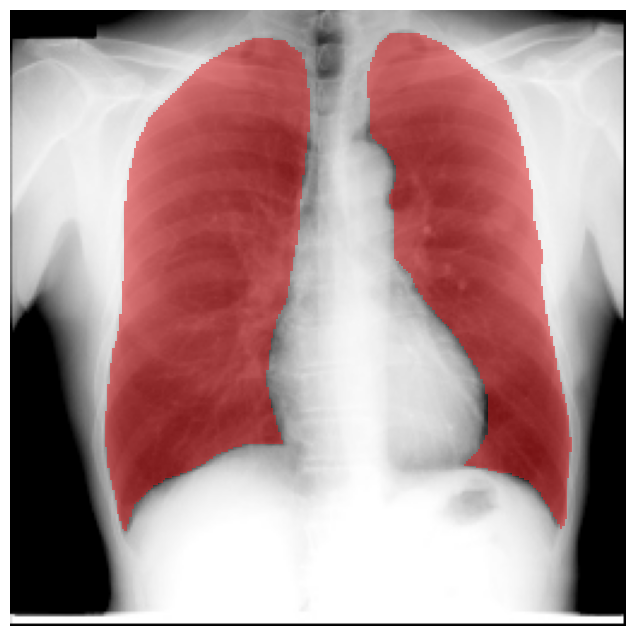

In [ ]:
# Load train/val/test data
x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)

# TODO:
# Bring images into the correct format for SAM:
# Image shape: (N, H, W, C=3)
# Mask shape: (N, H, W)
# Values: [0, 255] (uint8)

# YOUR CODE HERE

print("Initial shapes:")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Normalize and scale images to [0, 255]
x_train = map_interval(x_train, np.min(x_train), np.max(x_train), 0, 255)
x_val = map_interval(x_val, np.min(x_val), np.max(x_val), 0, 255)
x_test = map_interval(x_test, np.min(x_test), np.max(x_test), 0, 255)

print("After normalizing:")
print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"x_test shape: {x_test.shape}")

x_train = np.concatenate([x_train] * 3, axis=-1).astype(np.uint8)
x_val = np.concatenate([x_val] * 3, axis=-1).astype(np.uint8)
x_test = np.concatenate([x_test] * 3, axis=-1).astype(np.uint8)

print("After extending axis:")
print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"x_test shape: {x_test.shape}")

# Binarize masks to [0, 1]
y_train = (np.squeeze(y_train) > 0).astype(np.uint8)
y_val = (np.squeeze(y_val) > 0).astype(np.uint8)
y_test = (np.squeeze(y_test) > 0).astype(np.uint8)

print("Shapes after processing:")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# your data should pass the following asserts
assert x_train.shape == (112, 256, 256, 3)
assert y_train.shape == (112, 256, 256)
assert x_val.shape == (12, 256, 256, 3)
assert y_val.shape == (12, 256, 256)
assert x_test.shape == (123, 256, 256, 3)
assert y_test.shape == (123, 256, 256)

assert x_train.dtype == y_train.dtype == np.uint8
assert np.min(x_train) == 0
assert np.max(x_train) == 255

# Plot an example
fig, ax = plot_image_with_segmentation(x_train[0], y_train[0])
plt.show()

# Single Example image

Let's try to run SAM on a single example image

In [ ]:
example_img, example_mask = x_train[0], y_train[0]

input_points = np.array([[90,50],[80,150],[180,50],[210,150]]) # TODO: Pick apropriate input points,
input_label = np.array([1,1,1,1]) # TODO: Pick apropriate input labels

example_img.shape

(256, 256, 3)

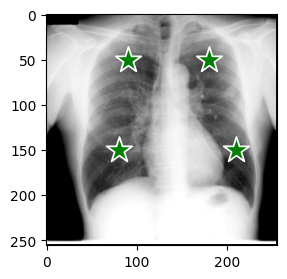

In [ ]:
plt.figure(figsize=(3,3))
plt.imshow(example_img)
show_points(input_points, input_label, plt.gca()) # You may also use other prompt methods!
plt.axis('on')
plt.show()

In [ ]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    multimask_output=True,
)

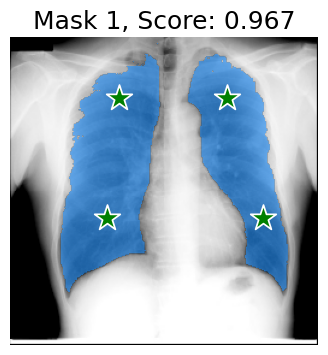

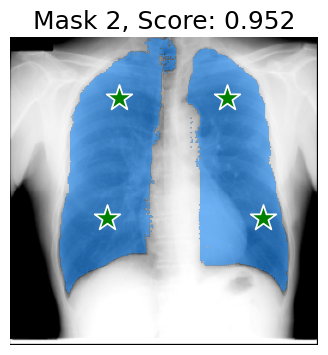

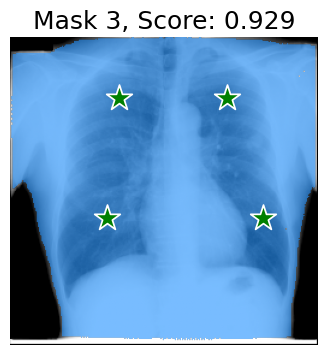

In [ ]:
# Note that the "score" here is an estimation of the mask quality, not the quality of the segmentation compared to the ground truth.
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(example_img.squeeze())
    show_mask(mask, plt.gca())
    show_points(input_points, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

# Evaluation loop

In [ ]:
f1 = torchmetrics.F1Score(task="binary")

f1_scores = []

for img, mask_gt in tqdm(zip(x_val, y_val), total=len(x_val), desc="Evaluating"):
    #raise NotImplementedError("TODO: Predict segmentation with SAM and compute F1 score.")
    # YOUR CODE HERE
    predictor.set_image(img)
    input_points = np.array([[90,50],[80,150],[180,50],[210,150]])
    input_labels = np.array([1,1,1,1])

    masks, _, _ = predictor.predict(point_coords=input_points,
                                    point_labels=input_labels,
                                    multimask_output=False)
    pred_mask = masks[0]
    pred_mask_tensor = torch.from_numpy(pred_mask)
    mask_gt_tensor = torch.from_numpy(mask_gt)
    f1_score = f1(pred_mask_tensor.flatten(), mask_gt_tensor.flatten())
    f1_scores.append(f1_score.item())

mean_f1 = np.mean(f1_scores) # TODO
std_f1 = np.std(f1_scores) # TODO

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")


Evaluating: 100%|██████████| 12/12 [00:24<00:00,  2.03s/it]

Mean F1 score: 0.7415
Standard deviation: 0.1112


# Using Bounding Boxes from GT segmentations as Prompt

In [ ]:
# bounding boxes from segmentation masks
# bonding box format [x0, y0, x1, y1]

# TODO: Implement bounding box extraction from segmentation masks
def generate_boxes(data):
    boxes = []
    for mask in data:
        coords = np.argwhere(mask == 1)
        if len(coords) == 0:
            boxes.append([[0, 0, 0, 0], [0, 0, 0, 0]])
            continue

        coords_left = coords[coords[:, 1] < mask.shape[1] // 2]
        coords_right = coords[coords[:, 1] >= mask.shape[1] // 2]

        box_left = [coords_left[:, 1].min(), coords_left[:, 0].min(),
                    coords_left[:, 1].max() + 1, coords_left[:, 0].max() + 1]

        box_right = [coords_right[:, 1].min(), coords_right[:, 0].min(),
                     coords_right[:, 1].max() + 1, coords_right[:, 0].max() + 1]

        boxes.append([box_left, box_right])

    return boxes

boxes_train = generate_boxes(y_train)
boxes_val = generate_boxes(y_val)
boxes_test = generate_boxes(y_test)

In [ ]:
print(len(boxes_val))
print(len(boxes_val[0]))
print(len(boxes_val[0][0]))

12
2
4


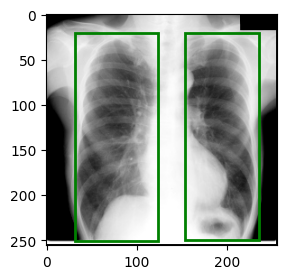

In [ ]:
example_img = x_val[10]
example_boxes = boxes_val[10]

plt.figure(figsize=(3, 3))
plt.imshow(example_img)
ax = plt.gca()
show_box(example_boxes[0], ax)  # Left lung bounding box
show_box(example_boxes[1], ax)  # Right lung bounding box
plt.axis('on')
plt.show()

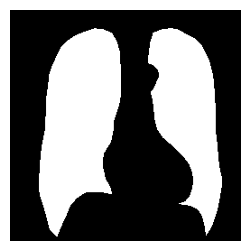

In [ ]:
mask = y_val[10]
plt.figure(figsize=(3, 3))
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:

f1_scores = []
for i, (img, mask_gt) in enumerate(tqdm(zip(x_val, y_val), total=len(x_val), desc="Evaluating")):
    predictor.set_image(img)
    boxes = np.array(boxes_val[i])  # Convert the list to a NumPy array

    # Initialize an empty mask for combining predictions
    combined_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    # Process each box individually
    for box in boxes:
        masks, _, _ = predictor.predict(
            box=box[np.newaxis, :],  # Ensure the box is in the correct shape
            multimask_output=False
        )
        combined_mask = np.logical_or(combined_mask, masks[0]).astype(np.uint8)
    # Convert masks to PyTorch tensors
    pred_mask_tensor = torch.from_numpy(combined_mask)
    mask_gt_tensor = torch.from_numpy(mask_gt)
    f1_score = f1(pred_mask_tensor.flatten(), mask_gt_tensor.flatten())
    f1_scores.append(f1_score.item())

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")


Evaluating: 100%|██████████| 12/12 [00:26<00:00,  2.18s/it]

Mean F1 score: 0.9218
Standard deviation: 0.0230


# Object Detection Model to predict Bounding Boxes

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/ColabNotebooks/Yolo8

In [ ]:
#!pip install --target="/content/drive/MyDrive/ColabNotebooks/Yolo8" ultralytics

In [ ]:
base_path = '/content/drive/MyDrive/ColabNotebooks/Yolo8/data'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

!ls /content/drive/MyDrive/ColabNotebooks/Yolo8

certifi					     pillow.libs
contourpy				     __pycache__
cycler					     py_cpuinfo-9.0.0.dist-info
data					     pylab.py
dateutil				     python_dateutil-2.9.0.post0.dist-info
fsspec-2024.6.0.dist-info		     PyYAML-6.0.1.dist-info
idna					     requests
lung_detection.yaml			     scipy
markupsafe				     scipy-1.13.1.dist-info
MarkupSafe-2.1.5.dist-info		     seaborn-0.13.2.dist-info
matplotlib				     six-1.16.0.dist-info
mpmath-1.3.0.dist-info			     six.py
numpy-1.26.4.dist-info			     sympy-1.12.1.dist-info
nvidia_cublas_cu12-12.1.3.1.dist-info	     torch
nvidia_cuda_nvrtc_cu12-12.1.105.dist-info    torch-2.3.1.dist-info
nvidia_cuda_runtime_cu12-12.1.105.dist-info  torchvision
nvidia_curand_cu12-10.3.2.106.dist-info      torchvision-0.18.1.dist-info
nvidia_cusparse_cu12-12.1.0.106.dist-info    torchvision.libs
nvidia_nccl_cu12-2.20.5.dist-info	     tqdm-4.66.4.dist-info
nvidia_nvjitlink_cu12-12.5.40.dist-info      triton
opencv_python.libs			     triton-2.3.1.dist-info
packagin

In [ ]:
def save_yolo_annotations(images, boxes, output_dir, class_id=0):
    os.makedirs(output_dir, exist_ok=True)
    for i, (image, box) in enumerate(zip(images, boxes)):
        image_name = f'image_{i}.jpg'
        annotation_name = f'image_{i}.txt'

        # Save the image
        image_path = os.path.join(output_dir, image_name)
        cv2.imwrite(image_path, image)

        # Save the annotation
        annotation_path = os.path.join(output_dir, annotation_name)
        with open(annotation_path, 'w') as f:
            for b in box:
                x_center = (b[0] + b[2]) / 2.0 / image.shape[1]
                y_center = (b[1] + b[3]) / 2.0 / image.shape[0]
                width = (b[2] - b[0]) / image.shape[1]
                height = (b[3] - b[1]) / image.shape[0]
                f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

# Save annotations for train, val, and test sets
save_yolo_annotations(x_train, boxes_train, train_path)
save_yolo_annotations(x_val, boxes_val, val_path)
save_yolo_annotations(x_test, boxes_test, test_path)


In [ ]:
print("Train files:")
!ls /content/drive/MyDrive/ColabNotebooks/Yolo8/data/train
print("Val files:")
!ls /content/drive/MyDrive/ColabNotebooks/Yolo8/data/val
print("Test files:")
!ls /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test

Train files:
image_0.jpg    image_13.jpg  image_28.jpg  image_42.jpg  image_57.jpg  image_71.jpg  image_86.jpg
image_0.txt    image_13.txt  image_28.txt  image_42.txt  image_57.txt  image_71.txt  image_86.txt
image_100.jpg  image_14.jpg  image_29.jpg  image_43.jpg  image_58.jpg  image_72.jpg  image_87.jpg
image_100.txt  image_14.txt  image_29.txt  image_43.txt  image_58.txt  image_72.txt  image_87.txt
image_101.jpg  image_15.jpg  image_2.jpg   image_44.jpg  image_59.jpg  image_73.jpg  image_88.jpg
image_101.txt  image_15.txt  image_2.txt   image_44.txt  image_59.txt  image_73.txt  image_88.txt
image_102.jpg  image_16.jpg  image_30.jpg  image_45.jpg  image_5.jpg   image_74.jpg  image_89.jpg
image_102.txt  image_16.txt  image_30.txt  image_45.txt  image_5.txt   image_74.txt  image_89.txt
image_103.jpg  image_17.jpg  image_31.jpg  image_46.jpg  image_60.jpg  image_75.jpg  image_8.jpg
image_103.txt  image_17.txt  image_31.txt  image_46.txt  image_60.txt  image_75.txt  image_8.txt
image_104

In [ ]:
yaml_content = """
path: /content/drive/MyDrive/ColabNotebooks/Yolo8/data
train: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/train
val: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/val
test: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test

# Classes
names:
  0: Lung
"""

with open('/content/drive/MyDrive/ColabNotebooks/Yolo8/lung_detection.yaml', 'w') as f:
    f.write(yaml_content)

# Verify the file was created
!cat /content/drive/MyDrive/ColabNotebooks/Yolo8/lung_detection.yaml


path: /content/drive/MyDrive/ColabNotebooks/Yolo8/data
train: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/train
val: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/val
test: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test

# Classes
names:
  0: Lung


In [ ]:
!ls /content/drive/MyDrive/ColabNotebooks/Yolo8/data

test  test.cache  train  train.cache  val  val.cache


In [ ]:
# TODO: Implement an object detection model to find the left and right lung bounding boxes


In [ ]:
model = YOLO("yolov8n.pt")

model.tune(data="/content/drive/MyDrive/ColabNotebooks/Yolo8/lung_detection.yaml", pretrained=True, epochs=30, iterations=10, optimizer="AdamW", plots=False, save=False, val=False)



Tuner: Initialized Tuner instance with 'tune_dir=runs/detect/tune5'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/10 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
Saved runs/detect/tune5/tune_scatter_plots.png
Saved runs/detect/tune5/tune_fitness.png

Tuner: 1/10 iterations complete ✅ (98.10s)
Tuner: Results saved to runs/detect/tune5
Tuner: Best fitness=0.86358 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.99695, 'metrics/recall(B)': 1.0, 'metrics/mAP50(B)': 0.995, 'metrics/mAP50-95(B)': 0.84898, 'val/box_loss': 0.61895, 'val/cls_loss': 0.41

In [ ]:
import yaml
best_hyperparameters_path = "runs/detect/tune/best_hyperparameters.yaml"
with open(best_hyperparameters_path, 'r') as file:
    best_hyperparameters = yaml.safe_load(file)
    print("Best hyperparameters found during tuning:")
    print(best_hyperparameters)

Best hyperparameters found during tuning:
{'lr0': 0.01053, 'lrf': 0.00942, 'momentum': 0.92474, 'weight_decay': 0.00051, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8702, 'box': 7.04806, 'cls': 0.5, 'dfl': 1.13608, 'hsv_h': 0.01354, 'hsv_s': 0.80121, 'hsv_v': 0.22089, 'degrees': 0.0, 'translate': 0.10097, 'scale': 0.61078, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.49748, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}


training

In [ ]:
best_hyperparameters = {'lr0': 0.01053,
                        'lrf': 0.00942,
                        'momentum': 0.92474,
                        'weight_decay': 0.00051,
                        'warmup_epochs': 3.0,
                        'warmup_momentum': 0.8702,
                        'box': 7.04806,
                        'cls': 0.5,
                        'dfl': 1.13608,
                        'hsv_h': 0.01354,
                        'hsv_s': 0.80121,
                        'hsv_v': 0.22089,
                        'degrees': 0.0,
                        'translate': 0.10097,
                        'scale': 0.61078,
                        'shear': 0.0,
                        'perspective': 0.0,
                        'flipud': 0.0,
                        'fliplr': 0.49748,
                        'bgr': 0.0,
                        'mosaic': 1.0,
                        'mixup': 0.0,
                        'copy_paste': 0.0
                        }

results = model.train(
    data="/content/drive/MyDrive/ColabNotebooks/Yolo8/lung_detection.yaml",
    epochs=200,
    pretrained=True,
    visualize=True,
    imgsz=640,
    batch=16,
    optimizer="AdamW",
    **best_hyperparameters
    )


Ultralytics YOLOv8.2.41 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/ColabNotebooks/Yolo8/lung_detection.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train23, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=True, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False,

train: Scanning /content/drive/MyDrive/ColabNotebooks/Yolo8/data/train.cache... 112 images, 0 backgrounds, 0 corrupt: 100%|██████████| 112/112 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/ColabNotebooks/Yolo8/data/val.cache... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<?, ?it/s]


Plotting labels to runs/detect/train23/labels.jpg... 
optimizer: AdamW(lr=0.01053, momentum=0.92474) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00051), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train23
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      5.22G     0.8483      1.105     0.9292         63        640: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

                   all         12         24      0.221      0.458      0.193     0.0517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      4.91G      1.176      1.249      1.093         69        640: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         12         24      0.253      0.458      0.248      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      4.94G      1.081     0.9905      1.016         80        640: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         12         24     0.0142      0.208     0.0084    0.00205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      4.94G       1.01     0.8949     0.9885         79        640: 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         12         24    0.00316      0.333    0.00209   0.000403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      4.92G     0.9841     0.7664     0.9774         66        640: 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         12         24     0.0242      0.542     0.0191    0.00523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      4.94G      1.054     0.7646     0.9543         98        640: 100%|██████████| 7/7 [00:01<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

                   all         12         24     0.0242      0.542     0.0191    0.00523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      4.94G      1.012     0.7471      0.976         71        640: 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         12         24     0.0976      0.292     0.0613     0.0115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      4.94G       1.08     0.7753     0.9878         70        640: 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         12         24     0.0281      0.458      0.026     0.0053



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      4.94G      1.054     0.7832      1.011         95        640: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         12         24      0.018      0.208     0.0102    0.00209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      4.94G      1.024     0.7618     0.9751         80        640: 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         12         24    0.00199     0.0833   0.000534   7.69e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      4.94G      1.065     0.7827     0.9695         65        640: 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         12         24    0.00256      0.208     0.0014   0.000187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      4.94G     0.9989     0.7401     0.9652         73        640: 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         12         24       0.17      0.417      0.128     0.0414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      4.94G     0.9844     0.7077     0.9785         63        640: 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         12         24      0.119      0.417     0.0903     0.0168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      4.94G      0.967     0.6775     0.9146         78        640: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         12         24      0.126        0.5      0.111     0.0337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      4.94G     0.9862     0.7089     0.9363         70        640: 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all         12         24      0.437      0.389      0.372      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      4.94G     0.9768     0.6889     0.9648         73        640: 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         12         24      0.211        0.5      0.212     0.0459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      4.94G     0.9102     0.6326     0.9012         70        640: 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

                   all         12         24       0.37      0.625      0.427      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      4.94G     0.9481     0.6465     0.9097         88        640: 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         12         24      0.284      0.208      0.169     0.0871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      4.94G     0.9405     0.6847     0.9216         63        640: 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         12         24      0.421        0.5       0.35     0.0816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      4.94G     0.8215     0.6186     0.8769         67        640: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         12         24      0.261      0.333      0.177     0.0679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      4.94G     0.8479     0.6078     0.8942         73        640: 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         12         24      0.131       0.25     0.0718     0.0224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      4.94G     0.8459     0.5997     0.8998         73        640: 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         12         24      0.118      0.292     0.0768     0.0111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      4.94G     0.8083     0.5705     0.8552         64        640: 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         12         24     0.0604      0.167     0.0161    0.00564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      4.94G     0.8055     0.5598     0.8512         72        640: 100%|██████████| 7/7 [00:01<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

                   all         12         24      0.286      0.208     0.0877     0.0212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      4.94G     0.8311     0.5795     0.8857         86        640: 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         12         24     0.0541      0.208     0.0195    0.00279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      4.94G     0.8358     0.5785     0.8863         64        640: 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         12         24      0.312       0.75      0.332     0.0829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      4.94G     0.7692     0.5312     0.8334         67        640: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         12         24      0.876      0.958      0.979      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      4.94G     0.7257     0.5057     0.8129         80        640: 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         12         24      0.712      0.958      0.972      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      4.94G     0.7521      0.516     0.8286         81        640: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         12         24      0.789          1      0.973      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      4.94G     0.7379     0.5065      0.815         83        640: 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         12         24       0.98          1      0.995      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      4.94G     0.8148     0.5493     0.8446         85        640: 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         12         24      0.887          1      0.987        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      4.94G     0.7775     0.5237     0.8238         58        640: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         12         24      0.627      0.708      0.661      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      4.94G     0.8045     0.5464     0.8481         80        640: 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         12         24      0.944          1      0.992       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      4.94G     0.7336     0.5171     0.8274         72        640: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         12         24      0.706      0.902       0.88      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      4.94G      0.766     0.5118     0.8181         77        640: 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         12         24      0.889      0.958      0.922      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      4.94G     0.7776     0.5163      0.854         56        640: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         12         24      0.913      0.958       0.95      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      4.94G     0.7245     0.5079     0.8151         64        640: 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         12         24          1      0.904      0.943      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      4.92G     0.7107     0.5092     0.8321         70        640: 100%|██████████| 7/7 [00:01<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


                   all         12         24      0.996          1      0.995      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      4.94G     0.7084     0.5128     0.8277         69        640: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         12         24      0.995          1      0.995      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      4.94G     0.7306     0.4964     0.8029         76        640: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         12         24      0.992          1      0.995      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      4.94G     0.6847       0.47      0.794         64        640: 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         12         24      0.957          1      0.989      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      4.94G     0.6937     0.4726      0.804         65        640: 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         12         24      0.952          1      0.993      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      4.94G     0.7105     0.4847     0.8275         84        640: 100%|██████████| 7/7 [00:01<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

                   all         12         24      0.872      0.852      0.947      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      4.94G     0.6669     0.4565     0.8132         78        640: 100%|██████████| 7/7 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         12         24      0.916          1       0.99      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      4.94G     0.6883     0.4906     0.8315         68        640: 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         12         24      0.971          1      0.995      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      4.94G     0.6656     0.4598      0.792         71        640: 100%|██████████| 7/7 [00:02<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         12         24      0.995          1      0.995      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      4.94G     0.6924     0.4649     0.8178         63        640: 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         12         24      0.996          1      0.995      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      4.94G      0.617     0.4294     0.7781         71        640: 100%|██████████| 7/7 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         12         24      0.995          1      0.995      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      4.94G     0.6636     0.4579     0.7992         66        640: 100%|██████████| 7/7 [00:01<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

                   all         12         24      0.996          1      0.995      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      4.94G     0.6646     0.4514     0.8016         76        640: 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         12         24      0.993          1      0.995      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      4.94G     0.6752     0.4563     0.8087         66        640: 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         12         24      0.715      0.917      0.862      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      4.94G     0.6279     0.4462     0.7922         60        640: 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         12         24      0.994          1      0.995       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      4.92G     0.6357     0.4642     0.8019         60        640: 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         12         24       0.96      0.994      0.977      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      4.94G     0.6532       0.45     0.7853         67        640: 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         12         24      0.996          1      0.995      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      4.94G     0.6762     0.4505     0.8182         64        640: 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         12         24      0.956      0.958      0.961      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      4.94G     0.6407     0.4285     0.8002         59        640: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         12         24      0.954          1      0.989      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      4.94G     0.6644     0.4393     0.7799         77        640: 100%|██████████| 7/7 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         12         24      0.982          1      0.995      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      4.94G     0.6693     0.4443     0.7912         72        640: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         12         24      0.773          1      0.957      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      4.94G     0.6535       0.44     0.7872         82        640: 100%|██████████| 7/7 [00:02<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         12         24      0.921          1      0.992      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      4.94G     0.6794      0.451     0.7936         73        640: 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         12         24      0.994          1      0.995      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      4.94G     0.6555     0.4509     0.8154         67        640: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         12         24      0.801      0.875      0.931       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      4.94G     0.6652     0.4483     0.8035         62        640: 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all         12         24      0.997          1      0.995      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      4.94G     0.6394     0.4385     0.7946         59        640: 100%|██████████| 7/7 [00:01<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         12         24      0.919          1      0.987      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      4.94G     0.6316      0.441     0.7916         78        640: 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         12         24      0.997          1      0.995      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      4.94G     0.6425     0.4297     0.7929         82        640: 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         12         24      0.996          1      0.995      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      4.94G     0.5981     0.4286     0.7835         69        640: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         12         24      0.996          1      0.995      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      4.94G     0.6232      0.423     0.7834         62        640: 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         12         24       0.99          1      0.995      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      4.94G     0.6532     0.4433     0.8002         49        640: 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         12         24      0.997          1      0.995      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      4.94G     0.6369      0.423     0.7707         70        640: 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         12         24      0.958          1      0.993      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      4.94G     0.6575     0.4237     0.8244         67        640: 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         12         24      0.979          1      0.995      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      4.94G     0.6448     0.4222     0.7962         67        640: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         12         24      0.918          1      0.993       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      4.94G     0.6269     0.4118     0.7787         67        640: 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         12         24      0.985          1      0.995      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      4.94G     0.6427     0.4134     0.7788         71        640: 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         12         24       0.99          1      0.995      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      4.94G     0.6291     0.4343     0.7813         66        640: 100%|██████████| 7/7 [00:01<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         12         24      0.991          1      0.995      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      4.94G     0.6012     0.4033     0.7719         78        640: 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         12         24      0.997          1      0.995      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      4.94G     0.5912     0.3885      0.772         82        640: 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         12         24      0.918          1      0.989      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      4.94G     0.6232     0.4196     0.7957         75        640: 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         12         24      0.912      0.958      0.976      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      4.94G     0.5973     0.4075     0.7815         78        640: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all         12         24      0.997          1      0.995      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      4.94G     0.6301     0.4096     0.7671         82        640: 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         12         24      0.995      0.917      0.945      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      4.94G     0.6079      0.424     0.7906         75        640: 100%|██████████| 7/7 [00:01<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         12         24       0.88      0.913      0.908      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      4.94G     0.5761     0.3952     0.7471         79        640: 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         12         24      0.996          1      0.995      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      4.94G     0.5834     0.3921      0.757         86        640: 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


                   all         12         24      0.923      0.996      0.989      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      4.94G     0.5921     0.3955     0.7694         64        640: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         12         24      0.998          1      0.995      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      4.92G     0.5763       0.39     0.7733         61        640: 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         12         24      0.998          1      0.995       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      4.94G     0.5753     0.3803     0.7688         85        640: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all         12         24          1      0.993      0.995      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      4.94G     0.5894     0.4012     0.7753         62        640: 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

                   all         12         24      0.985          1      0.995      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      4.94G     0.5816     0.3896     0.7525         80        640: 100%|██████████| 7/7 [00:01<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         12         24      0.957          1      0.995      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      4.94G     0.5799     0.3945     0.7534         77        640: 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         12         24      0.993          1      0.995      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      4.94G     0.5684     0.3837     0.7839         80        640: 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         12         24      0.957          1      0.993      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      4.94G      0.585     0.3848     0.7652         86        640: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         12         24      0.998          1      0.995       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      4.94G     0.5922     0.3928     0.7773         75        640: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         12         24      0.997          1      0.995      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      4.94G     0.5407     0.3889     0.7515         66        640: 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         12         24      0.997          1      0.995      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      4.94G     0.5588     0.3664     0.7727         70        640: 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         12         24      0.997          1      0.995      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      4.94G     0.5618     0.3619     0.7679         71        640: 100%|██████████| 7/7 [00:01<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         12         24      0.997          1      0.995      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      4.94G     0.5388     0.3678     0.7445         74        640: 100%|██████████| 7/7 [00:01<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         12         24       0.99          1      0.995      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      4.94G     0.5891     0.3866     0.7821         79        640: 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         12         24      0.997          1      0.995      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      4.92G      0.562      0.373     0.7708         67        640: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         12         24      0.995          1      0.995      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      4.94G     0.5565     0.3736     0.7613         63        640: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         12         24      0.997          1      0.995       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      4.94G     0.5666     0.3864     0.7584         68        640: 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         12         24      0.983          1      0.995      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      4.94G      0.566       0.37     0.7625         72        640: 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         12         24      0.997          1      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      4.94G     0.5754     0.3905     0.7869         50        640: 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         12         24      0.997          1      0.995      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      4.94G     0.5469     0.3648     0.7666         67        640: 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         12         24          1      0.997      0.995      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      4.94G     0.5328     0.3516     0.7519         71        640: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         12         24      0.951      0.917      0.978      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      4.94G     0.5754     0.3748     0.7886         67        640: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         12         24      0.957          1      0.993      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      4.94G     0.5609     0.3881     0.7702         57        640: 100%|██████████| 7/7 [00:01<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         12         24      0.956      0.914      0.965      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      4.94G     0.5646     0.3663     0.7682         81        640: 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         12         24      0.905      0.917      0.898       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      4.94G     0.5206     0.3429     0.7491         60        640: 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         12         24      0.996          1      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      4.94G     0.5008     0.3319     0.7387         76        640: 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         12         24          1      0.999      0.995      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      4.94G     0.5303     0.3663     0.7732         71        640: 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         12         24      0.998          1      0.995      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      4.94G     0.5284     0.3444     0.7758         65        640: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         12         24      0.997          1      0.995      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      4.94G     0.4962     0.3337     0.7353         67        640: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         12         24      0.998          1      0.995      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      4.94G     0.5117     0.3329      0.741         85        640: 100%|██████████| 7/7 [00:01<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         12         24      0.998          1      0.995      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      4.94G     0.5175     0.3615     0.7542         64        640: 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         12         24      0.995          1      0.995      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      4.94G     0.5362     0.3596     0.7613         75        640: 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         12         24      0.998          1      0.995      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      4.94G     0.5221     0.3493     0.7527         83        640: 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         12         24      0.997          1      0.995      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      4.94G      0.544     0.3523     0.7706         66        640: 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         12         24      0.997          1      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      4.94G     0.5239     0.3457     0.7525         67        640: 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         12         24      0.997          1      0.995      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      4.92G     0.5137     0.3479      0.766         63        640: 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         12         24      0.943      0.917      0.965      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      4.94G     0.5406     0.3466     0.7459         82        640: 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         12         24      0.908      0.917      0.927      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      4.94G     0.5156     0.3457      0.742         80        640: 100%|██████████| 7/7 [00:01<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]

                   all         12         24      0.998          1      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      4.94G     0.5511     0.3755     0.7858         67        640: 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         12         24      0.997          1      0.995      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      4.94G     0.5205     0.3442     0.7358         77        640: 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         12         24      0.952          1      0.989      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      4.94G     0.4873       0.33     0.7398         75        640: 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         12         24      0.985          1      0.995      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      4.94G     0.5369     0.3694     0.7534         70        640: 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         12         24      0.998          1      0.995      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      4.94G     0.5318     0.3468     0.7585         84        640: 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         12         24      0.997          1      0.995       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      4.94G     0.5466      0.358     0.7807         58        640: 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         12         24      0.919      0.958      0.958      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      4.94G     0.5137     0.3457       0.74         82        640: 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         12         24      0.998          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      4.94G     0.5251     0.3715     0.7621         63        640: 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         12         24      0.998          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      4.94G     0.5528     0.3547     0.7658         61        640: 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         12         24      0.998          1      0.995      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      4.94G     0.4771     0.3385     0.7286         69        640: 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         12         24      0.998          1      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      4.94G     0.5234     0.3353     0.7623         59        640: 100%|██████████| 7/7 [00:01<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         12         24      0.998          1      0.995      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      4.94G     0.4852      0.324     0.7439         60        640: 100%|██████████| 7/7 [00:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

                   all         12         24      0.958          1      0.993      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      4.94G     0.4979     0.3456     0.7592         59        640: 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         12         24      0.851      0.958      0.988      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      4.94G     0.4913     0.3262     0.7387         68        640: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         12         24      0.998          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      4.94G     0.5152     0.3418     0.7532         64        640: 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         12         24      0.958      0.958      0.986      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      4.94G     0.5044     0.3201     0.7171         75        640: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         12         24      0.923      0.993      0.989      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      4.94G     0.4669     0.3125     0.7224         92        640: 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         12         24      0.998          1      0.995      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      4.94G     0.4912     0.3162     0.7386         69        640: 100%|██████████| 7/7 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         12         24      0.998          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      4.94G     0.5026     0.3205     0.7443         76        640: 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

                   all         12         24      0.998          1      0.995      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      4.92G      0.481     0.3151      0.731         70        640: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         12         24      0.998          1      0.995      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      4.94G     0.4943     0.3111     0.7447         76        640: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         12         24      0.998          1      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      4.94G     0.4931     0.3191     0.7556         70        640: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         12         24      0.998          1      0.995      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      4.94G     0.5049     0.3153     0.7459         77        640: 100%|██████████| 7/7 [00:01<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         12         24      0.998          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      4.94G     0.5035     0.3231     0.7396         63        640: 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         12         24      0.959          1      0.992      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      4.94G     0.4788     0.3057     0.7236         81        640: 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


                   all         12         24       0.96          1      0.992      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      4.94G     0.5097     0.3167     0.7402         74        640: 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         12         24      0.998          1      0.995      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      4.94G     0.4818     0.3178     0.7559         88        640: 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         12         24      0.998          1      0.995      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      4.94G     0.4924     0.3144     0.7486         69        640: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         12         24      0.998          1      0.995      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      4.94G     0.4777     0.3192      0.737         65        640: 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         12         24      0.998          1      0.995      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      4.94G     0.4974     0.3208     0.7367         67        640: 100%|██████████| 7/7 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all         12         24      0.998          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      4.94G     0.5023     0.3346     0.7618         61        640: 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         12         24      0.998          1      0.995      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      4.94G     0.4681     0.3098     0.7265         73        640: 100%|██████████| 7/7 [00:01<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

                   all         12         24      0.998          1      0.995       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      4.94G     0.4838     0.3166     0.7363         68        640: 100%|██████████| 7/7 [00:01<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         12         24      0.998          1      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      4.94G     0.4538     0.3052     0.7249         75        640: 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         12         24      0.998          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      4.94G     0.4744     0.3196     0.7345         49        640: 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         12         24      0.997          1      0.995      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      4.94G     0.4834     0.3062     0.7319         82        640: 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all         12         24      0.998          1      0.995      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      4.94G     0.4755     0.3043     0.7278         74        640: 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         12         24      0.998          1      0.995      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      4.94G     0.4767     0.2983     0.7487         78        640: 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         12         24      0.998          1      0.995      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      4.92G     0.4598     0.3155     0.7478         75        640: 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         12         24      0.998          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      4.94G     0.4569     0.3068     0.7186         64        640: 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         12         24      0.958          1      0.993      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      4.94G     0.4738     0.3162     0.7476         61        640: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         12         24      0.958          1      0.993      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      4.94G      0.456     0.2949     0.7296         78        640: 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         12         24      0.921      0.972      0.992      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      4.94G     0.4418     0.2945      0.721         91        640: 100%|██████████| 7/7 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         12         24      0.902          1      0.989      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      4.94G     0.4534     0.2955     0.7171         74        640: 100%|██████████| 7/7 [00:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         12         24      0.998          1      0.995      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      4.94G     0.4469     0.2973     0.7239         57        640: 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         12         24      0.998          1      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      4.94G     0.4537     0.2936     0.7382         70        640: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         12         24      0.998          1      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      4.94G     0.4268     0.2801       0.72         61        640: 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         12         24      0.998          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      4.94G      0.449     0.2891     0.7375         66        640: 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         12         24      0.998          1      0.995      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      4.94G     0.4559     0.2928     0.7278         64        640: 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         12         24      0.998          1      0.995      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      4.94G       0.46     0.2908     0.7449         66        640: 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         12         24      0.998          1      0.995      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      4.94G     0.4622     0.3061     0.7419         62        640: 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         12         24       0.88          1      0.974      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      4.94G     0.4368     0.2926     0.7246         65        640: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         12         24          1      0.946      0.966      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      4.94G     0.4399     0.2833     0.7203         69        640: 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         12         24      0.998          1      0.995      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      4.94G     0.4369     0.2922     0.7226         66        640: 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         12         24      0.998          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      4.94G     0.4996     0.3227     0.7711         77        640: 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         12         24          1      0.998      0.995      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      4.94G     0.4331     0.2795     0.7304         63        640: 100%|██████████| 7/7 [00:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

                   all         12         24      0.998          1      0.995      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      4.94G     0.4424     0.2838     0.7285         72        640: 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


                   all         12         24      0.998          1      0.995      0.951

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      4.94G     0.4296     0.2818      0.711         57        640: 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         12         24      0.998          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      4.94G     0.4576     0.2954     0.7462         61        640: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         12         24      0.998          1      0.995      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      4.94G     0.4324      0.284     0.7328         81        640: 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         12         24      0.998          1      0.995      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      4.94G     0.4171     0.2738      0.724         58        640: 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         12         24      0.998          1      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      4.94G      0.417      0.267     0.7175         73        640: 100%|██████████| 7/7 [00:01<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

                   all         12         24      0.998          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      4.94G      0.426     0.2705     0.7135         72        640: 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         12         24      0.998          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      4.94G     0.4247     0.2751     0.7169         62        640: 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         12         24      0.998          1      0.995      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      4.94G     0.4207     0.2739     0.7152         79        640: 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         12         24      0.998          1      0.995       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      4.94G     0.4207     0.2737     0.7209         81        640: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         12         24      0.998          1      0.995      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      4.94G     0.4315     0.2728     0.7396         62        640: 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         12         24      0.998          1      0.995      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      4.94G     0.4099     0.2729     0.7287         80        640: 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         12         24      0.998          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      4.94G     0.4188     0.2786      0.713         68        640: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         12         24      0.998          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      4.94G     0.4111     0.2729     0.7121         72        640: 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         12         24      0.998          1      0.995      0.947


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200       5.1G     0.3239     0.2588     0.7388         32        640: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         12         24      0.998          1      0.995      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      4.92G     0.3127     0.2504     0.7083         32        640: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         12         24      0.998          1      0.995      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      4.92G     0.3129     0.2329       0.73         32        640: 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         12         24      0.998          1      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      4.92G     0.3201     0.2345     0.7434         32        640: 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         12         24      0.998          1      0.995      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      4.92G     0.3166     0.2356     0.7424         32        640: 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         12         24      0.998          1      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      4.92G     0.3071      0.225     0.7373         32        640: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         12         24      0.998          1      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      4.92G     0.2968     0.2187     0.7197         32        640: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         12         24      0.998          1      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      4.92G      0.294     0.2127     0.7089         32        640: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         12         24      0.998          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      4.92G     0.2883     0.1964     0.6886         32        640: 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         12         24      0.998          1      0.995      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      4.92G     0.2863      0.206     0.6974         32        640: 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         12         24      0.998          1      0.995      0.947



200 epochs completed in 0.182 hours.
Optimizer stripped from runs/detect/train23/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train23/weights/best.pt, 6.3MB

Validating runs/detect/train23/weights/best.pt...
Ultralytics YOLOv8.2.41 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


                   all         12         24      0.998          1      0.995      0.958
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train23


In [ ]:
result_dir = 'runs/detect/train'

result_images = [os.path.join(result_dir, img) for img in os.listdir(result_dir) if img.endswith('.jpg')]

for img_path in result_images[:1]: 
    display(Image(filename=img_path))


In [ ]:
trained_model = YOLO('runs/detect/train23/weights/best.pt')

In [ ]:
test_dir = '/content/drive/MyDrive/ColabNotebooks/Yolo8/data/test'
test_images = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.jpg') or f.endswith('.png')]
test_results = trained_model.predict(source=test_images)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


0: 640x640 2 Lungs, 4.0ms
1: 640x640 2 Lungs, 4.0ms
2: 640x640 2 Lungs, 4.0ms
3: 640x640 2 Lungs, 4.0ms
4: 640x640 2 Lungs, 4.0ms
5: 640x640 2 Lungs, 4.0ms
6: 640x640 2 Lungs, 4.0ms
7: 640x640 2 Lungs, 4.0ms
8: 640x640 2 Lungs, 4.0ms
9: 640x640 2 Lungs, 4.0ms
10: 640x640 2 Lungs, 4.0ms
11: 640x640 2 Lungs, 4.0ms
12: 640x640 2 Lungs, 4.0ms
13: 640x640 2 Lungs, 4.0ms
14: 640x640 2 Lungs, 4.0ms
15: 640x640 2 Lungs, 4.0ms
16: 640x640 2 Lungs, 4.0ms
17: 640x640 2 Lungs, 4.0ms
18: 640x640 2 Lungs, 4.0ms
19: 640x640 2 Lungs, 4.0ms
20: 640x640 2 Lungs, 4.0ms
21: 640x640 2 Lungs, 4.0ms
22: 640x640 2 Lungs, 4.0ms
23: 640x640 2 Lungs, 4.0ms
24: 640x640 2 Lungs, 4.0ms
25: 640x640 2 Lungs, 4.0ms
26: 640x640 2 Lungs, 4.0ms
27: 640x640 2 Lungs, 4.0ms
28: 640x640 2 Lungs, 4.0ms
29: 640x640 2 Lungs, 4.0ms
30: 640x640 2 Lungs, 4.0ms
31: 640x640 2 Lungs, 4.0ms
32: 640x640 2 Lungs, 4.0ms
33: 640x640 2 Lungs, 4.0ms
34: 640x640 2 Lungs, 4.0ms
35: 640x640 2 Lungs, 4.0ms
36: 640x640 2 Lungs, 4.0ms
37: 640x640

In [ ]:
def draw_bboxes(image, boxes, scores, class_names, class_ids):
    for box, score, cls_name, cls_id in zip(boxes, scores, class_names, class_ids):
        x1, y1, x2, y2 = [int(coord) for coord in box]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"{cls_name} {score:.2f}"
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36, 255, 12), 2)

    return image


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_0.jpg: 640x640 2 Lungs, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


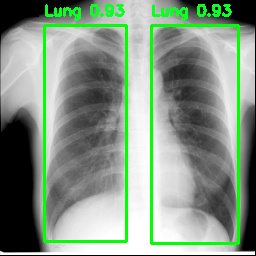


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_1.jpg: 640x640 2 Lungs, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


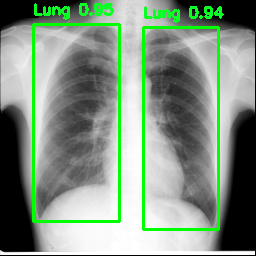


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_2.jpg: 640x640 2 Lungs, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


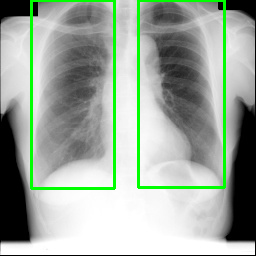


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_3.jpg: 640x640 2 Lungs, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


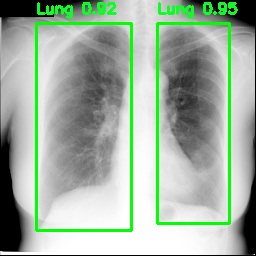


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_4.jpg: 640x640 2 Lungs, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


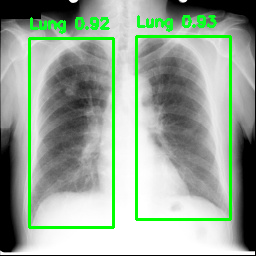


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_5.jpg: 640x640 2 Lungs, 7.4ms
Speed: 4.9ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


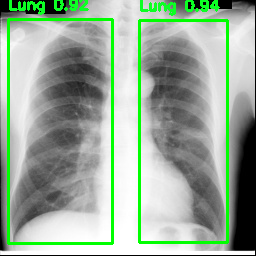


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_6.jpg: 640x640 2 Lungs, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)


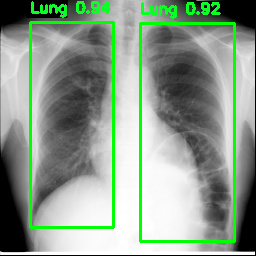


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_7.jpg: 640x640 2 Lungs, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


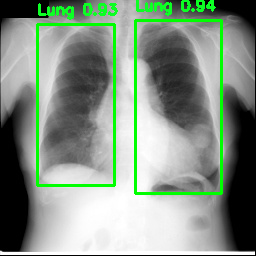


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_8.jpg: 640x640 2 Lungs, 10.6ms
Speed: 3.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


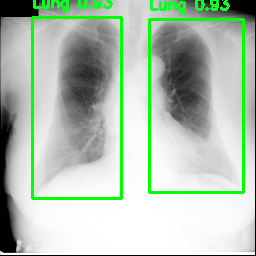


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_10.jpg: 640x640 2 Lungs, 15.9ms
Speed: 2.8ms preprocess, 15.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


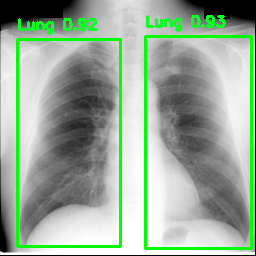


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_9.jpg: 640x640 2 Lungs, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


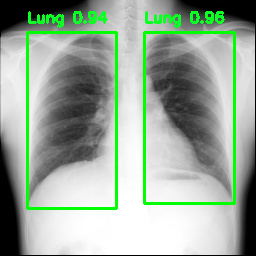


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_11.jpg: 640x640 2 Lungs, 11.6ms
Speed: 2.8ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


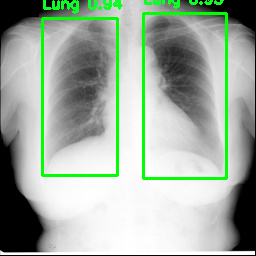


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_12.jpg: 640x640 2 Lungs, 16.5ms
Speed: 4.6ms preprocess, 16.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


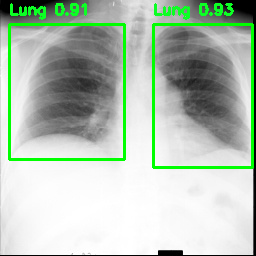


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_13.jpg: 640x640 2 Lungs, 11.2ms
Speed: 3.2ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


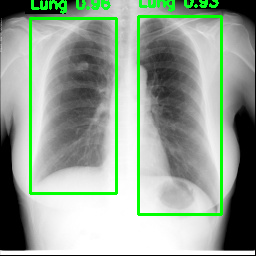


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_14.jpg: 640x640 2 Lungs, 13.1ms
Speed: 3.1ms preprocess, 13.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


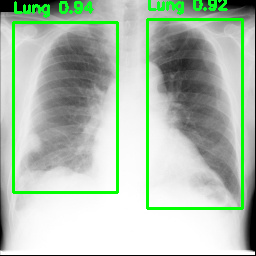


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_15.jpg: 640x640 2 Lungs, 12.0ms
Speed: 3.3ms preprocess, 12.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


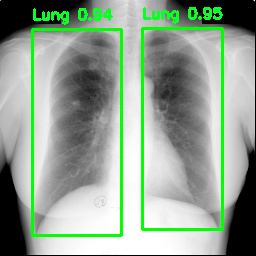


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_16.jpg: 640x640 2 Lungs, 14.3ms
Speed: 3.0ms preprocess, 14.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


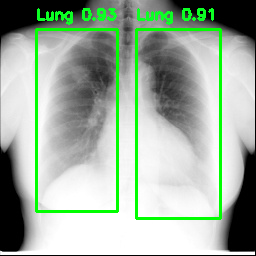


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_17.jpg: 640x640 2 Lungs, 10.1ms
Speed: 2.8ms preprocess, 10.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


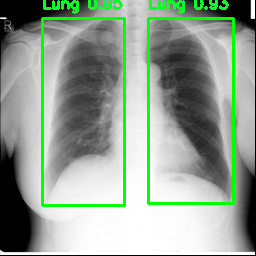


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_18.jpg: 640x640 2 Lungs, 10.1ms
Speed: 2.8ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


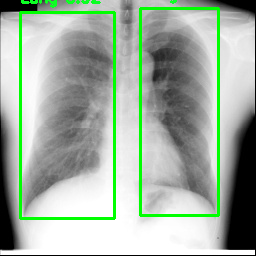


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_19.jpg: 640x640 2 Lungs, 13.4ms
Speed: 3.4ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


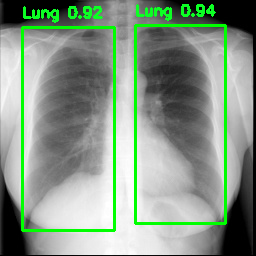


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_20.jpg: 640x640 2 Lungs, 14.4ms
Speed: 2.6ms preprocess, 14.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


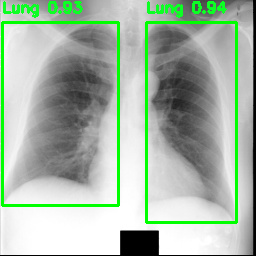


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_21.jpg: 640x640 2 Lungs, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)


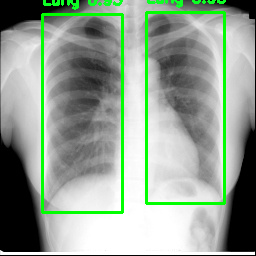


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_22.jpg: 640x640 2 Lungs, 13.5ms
Speed: 2.9ms preprocess, 13.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


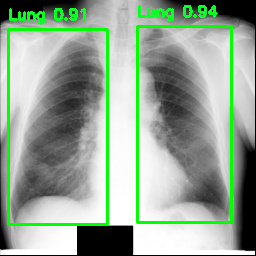


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_23.jpg: 640x640 2 Lungs, 16.1ms
Speed: 2.9ms preprocess, 16.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


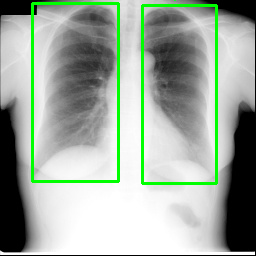


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_24.jpg: 640x640 2 Lungs, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


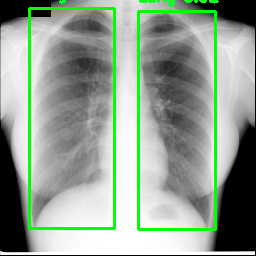


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_25.jpg: 640x640 2 Lungs, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


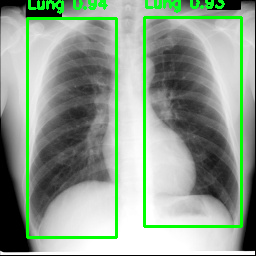


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_26.jpg: 640x640 2 Lungs, 18.4ms
Speed: 2.8ms preprocess, 18.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


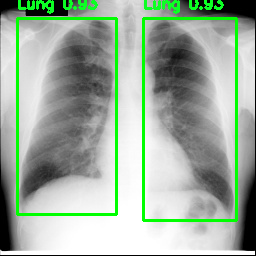


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_27.jpg: 640x640 2 Lungs, 13.4ms
Speed: 2.6ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


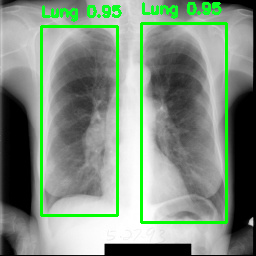


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_28.jpg: 640x640 2 Lungs, 17.1ms
Speed: 4.7ms preprocess, 17.1ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)


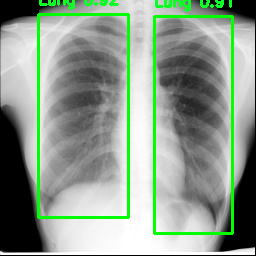


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_29.jpg: 640x640 2 Lungs, 14.3ms
Speed: 2.7ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


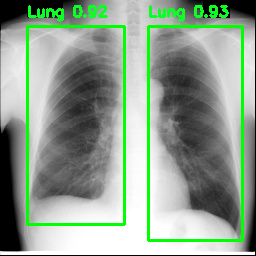


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_30.jpg: 640x640 2 Lungs, 11.8ms
Speed: 5.7ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


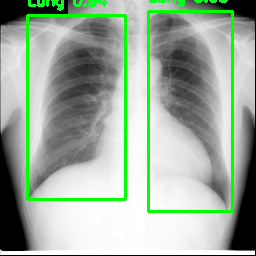


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_31.jpg: 640x640 2 Lungs, 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


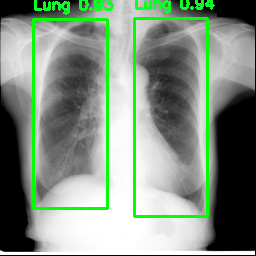


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_32.jpg: 640x640 2 Lungs, 17.0ms
Speed: 2.7ms preprocess, 17.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


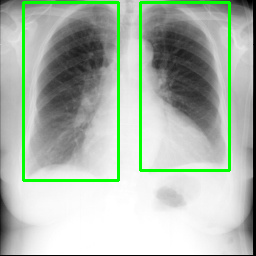


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_33.jpg: 640x640 2 Lungs, 13.6ms
Speed: 2.7ms preprocess, 13.6ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)


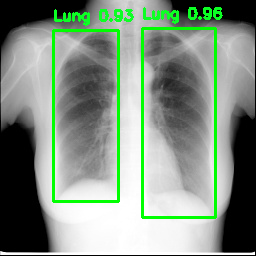


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_34.jpg: 640x640 2 Lungs, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


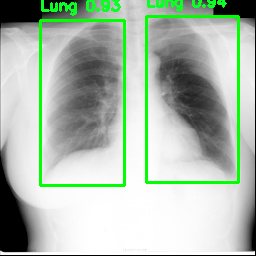


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_35.jpg: 640x640 2 Lungs, 12.9ms
Speed: 2.6ms preprocess, 12.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


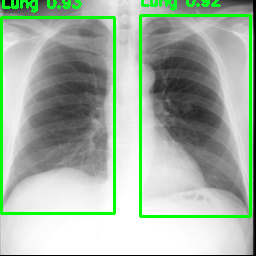


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_36.jpg: 640x640 2 Lungs, 13.8ms
Speed: 2.9ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


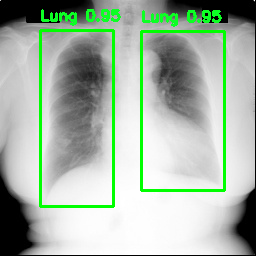


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_37.jpg: 640x640 2 Lungs, 11.6ms
Speed: 2.8ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


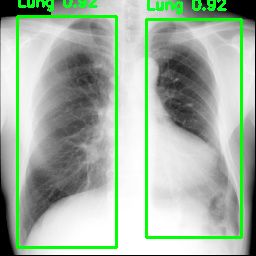


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_38.jpg: 640x640 2 Lungs, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)


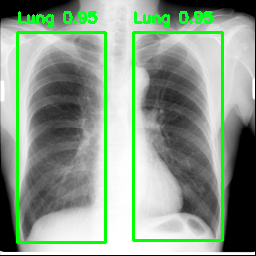


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_39.jpg: 640x640 2 Lungs, 11.5ms
Speed: 2.8ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


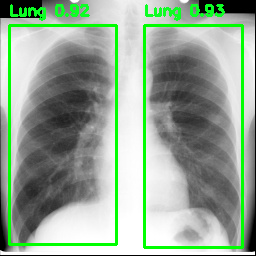


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_40.jpg: 640x640 2 Lungs, 13.5ms
Speed: 2.6ms preprocess, 13.5ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)


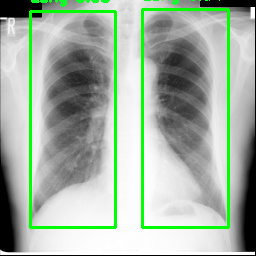


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_41.jpg: 640x640 2 Lungs, 18.2ms
Speed: 2.7ms preprocess, 18.2ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


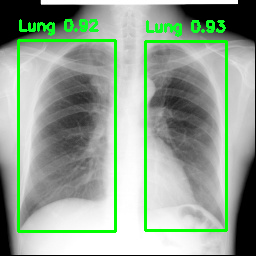


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_42.jpg: 640x640 2 Lungs, 13.2ms
Speed: 2.8ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


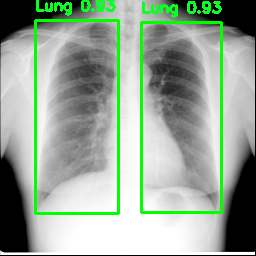


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_43.jpg: 640x640 2 Lungs, 12.1ms
Speed: 2.8ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


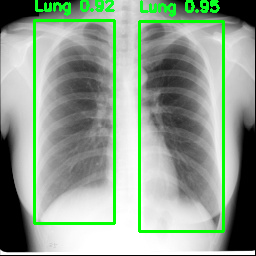


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_44.jpg: 640x640 2 Lungs, 15.5ms
Speed: 2.8ms preprocess, 15.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


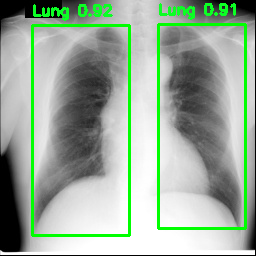


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_45.jpg: 640x640 2 Lungs, 11.7ms
Speed: 3.0ms preprocess, 11.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


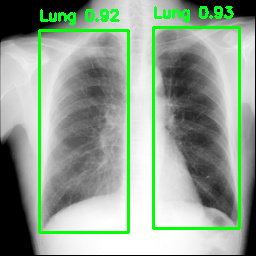


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_46.jpg: 640x640 2 Lungs, 14.4ms
Speed: 2.8ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


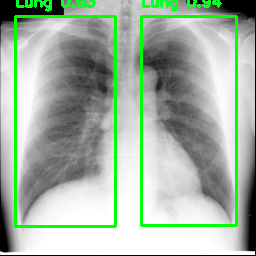


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_47.jpg: 640x640 2 Lungs, 20.5ms
Speed: 2.9ms preprocess, 20.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


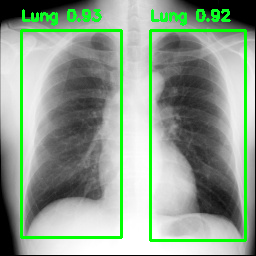


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_48.jpg: 640x640 2 Lungs, 13.2ms
Speed: 2.8ms preprocess, 13.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


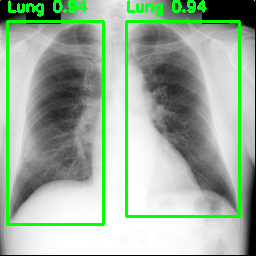


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_49.jpg: 640x640 2 Lungs, 17.0ms
Speed: 2.8ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


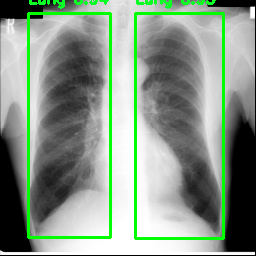


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_50.jpg: 640x640 2 Lungs, 13.4ms
Speed: 3.1ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


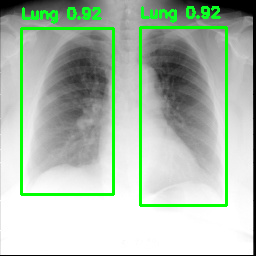


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_51.jpg: 640x640 2 Lungs, 20.0ms
Speed: 2.9ms preprocess, 20.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


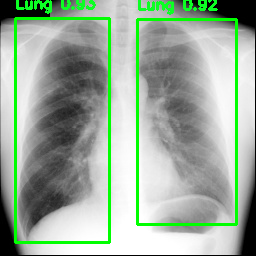


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_52.jpg: 640x640 2 Lungs, 14.1ms
Speed: 2.7ms preprocess, 14.1ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)


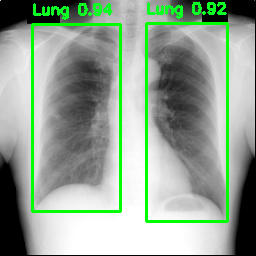


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_53.jpg: 640x640 2 Lungs, 20.4ms
Speed: 2.9ms preprocess, 20.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


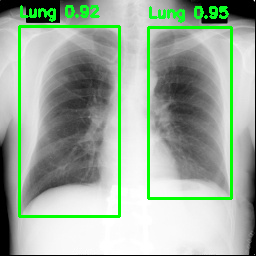


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_54.jpg: 640x640 2 Lungs, 15.1ms
Speed: 3.0ms preprocess, 15.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


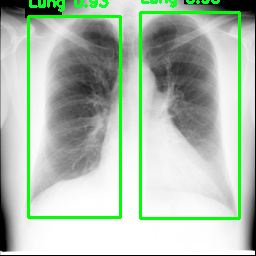


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_55.jpg: 640x640 2 Lungs, 11.2ms
Speed: 2.8ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


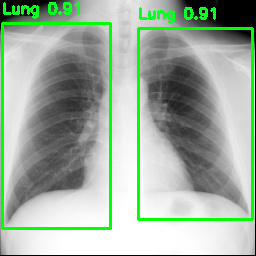


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_56.jpg: 640x640 2 Lungs, 10.4ms
Speed: 2.8ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


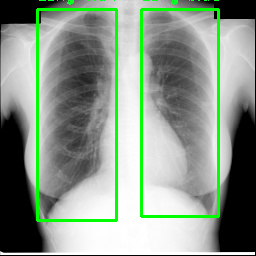


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_57.jpg: 640x640 2 Lungs, 12.5ms
Speed: 2.6ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


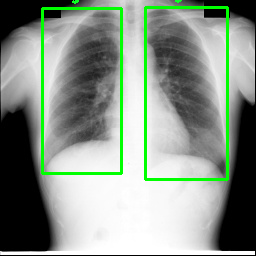


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_58.jpg: 640x640 2 Lungs, 15.0ms
Speed: 2.6ms preprocess, 15.0ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 640)


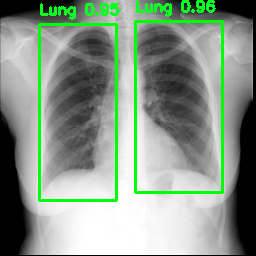


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_59.jpg: 640x640 2 Lungs, 14.0ms
Speed: 2.8ms preprocess, 14.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


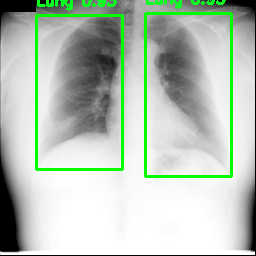


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_60.jpg: 640x640 2 Lungs, 17.8ms
Speed: 2.8ms preprocess, 17.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


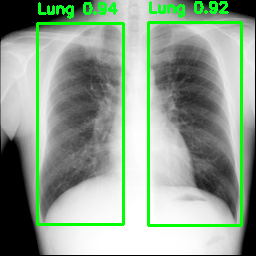


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_61.jpg: 640x640 2 Lungs, 14.8ms
Speed: 6.6ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


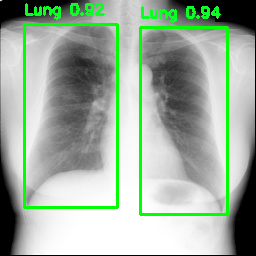


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_62.jpg: 640x640 2 Lungs, 14.8ms
Speed: 4.9ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


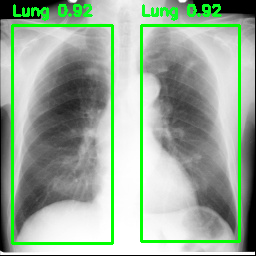


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_63.jpg: 640x640 2 Lungs, 14.4ms
Speed: 3.9ms preprocess, 14.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


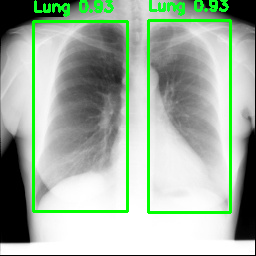


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_64.jpg: 640x640 2 Lungs, 20.0ms
Speed: 3.5ms preprocess, 20.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


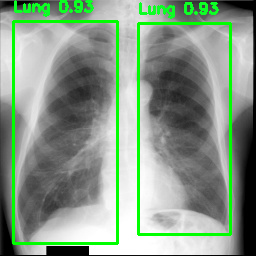


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_65.jpg: 640x640 2 Lungs, 19.1ms
Speed: 2.9ms preprocess, 19.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


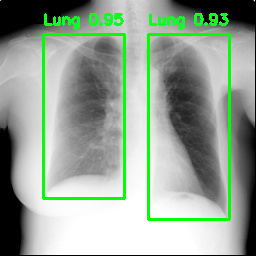


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_66.jpg: 640x640 2 Lungs, 14.5ms
Speed: 2.9ms preprocess, 14.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


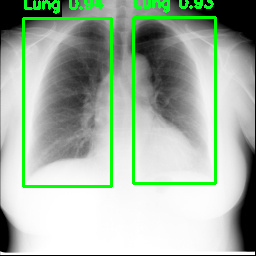


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_67.jpg: 640x640 2 Lungs, 18.6ms
Speed: 2.7ms preprocess, 18.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


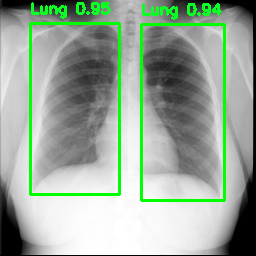


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_68.jpg: 640x640 2 Lungs, 20.9ms
Speed: 3.2ms preprocess, 20.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


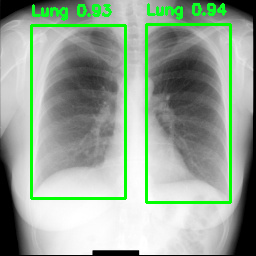


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_69.jpg: 640x640 2 Lungs, 16.1ms
Speed: 6.8ms preprocess, 16.1ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


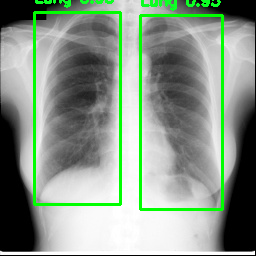


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_70.jpg: 640x640 2 Lungs, 14.2ms
Speed: 4.5ms preprocess, 14.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


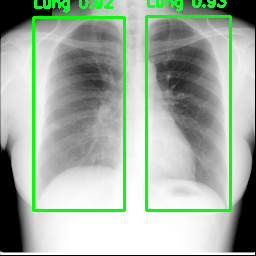


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_71.jpg: 640x640 2 Lungs, 14.5ms
Speed: 3.2ms preprocess, 14.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


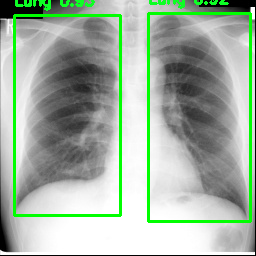


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_72.jpg: 640x640 2 Lungs, 19.1ms
Speed: 3.1ms preprocess, 19.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


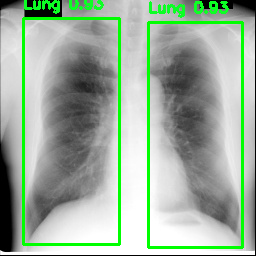


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_74.jpg: 640x640 2 Lungs, 19.2ms
Speed: 3.0ms preprocess, 19.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


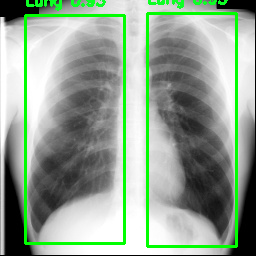


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_73.jpg: 640x640 2 Lungs, 24.4ms
Speed: 2.9ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


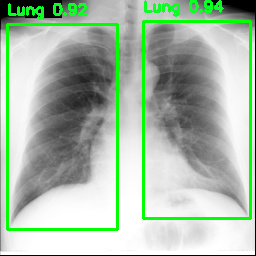


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_75.jpg: 640x640 2 Lungs, 18.4ms
Speed: 3.1ms preprocess, 18.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


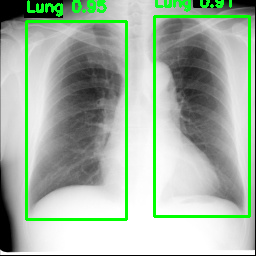


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_76.jpg: 640x640 2 Lungs, 15.3ms
Speed: 3.2ms preprocess, 15.3ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)


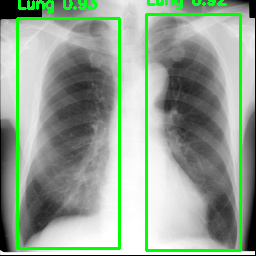


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_77.jpg: 640x640 2 Lungs, 12.8ms
Speed: 2.7ms preprocess, 12.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


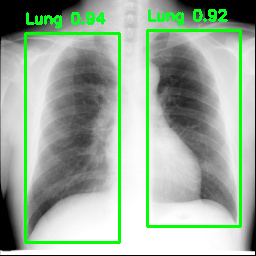


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_78.jpg: 640x640 2 Lungs, 15.4ms
Speed: 2.8ms preprocess, 15.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


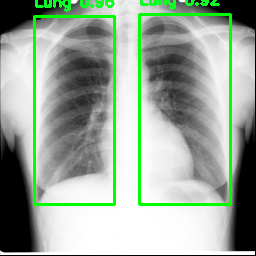


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_79.jpg: 640x640 2 Lungs, 21.0ms
Speed: 3.3ms preprocess, 21.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


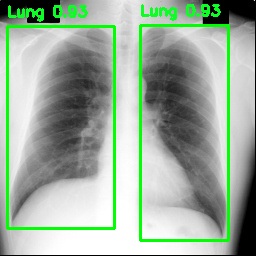


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_80.jpg: 640x640 2 Lungs, 23.6ms
Speed: 2.9ms preprocess, 23.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


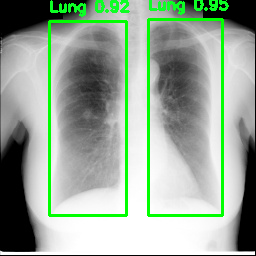


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_81.jpg: 640x640 2 Lungs, 15.1ms
Speed: 2.8ms preprocess, 15.1ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)


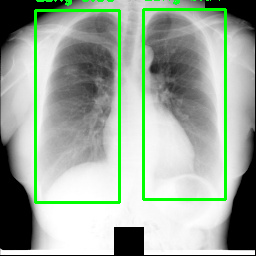


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_82.jpg: 640x640 2 Lungs, 15.4ms
Speed: 2.9ms preprocess, 15.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


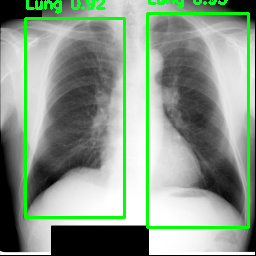


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_83.jpg: 640x640 2 Lungs, 19.0ms
Speed: 2.8ms preprocess, 19.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


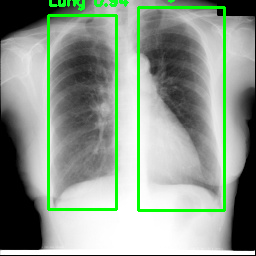


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_84.jpg: 640x640 2 Lungs, 16.6ms
Speed: 2.7ms preprocess, 16.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


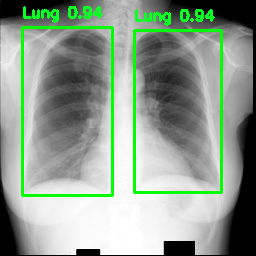


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_85.jpg: 640x640 2 Lungs, 16.9ms
Speed: 3.0ms preprocess, 16.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


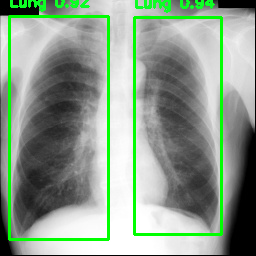


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_86.jpg: 640x640 2 Lungs, 17.9ms
Speed: 2.9ms preprocess, 17.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


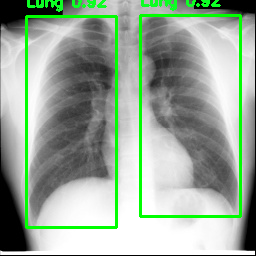


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_87.jpg: 640x640 2 Lungs, 17.6ms
Speed: 2.7ms preprocess, 17.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


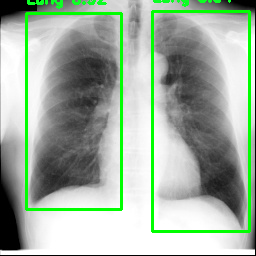


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_88.jpg: 640x640 2 Lungs, 16.4ms
Speed: 5.4ms preprocess, 16.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


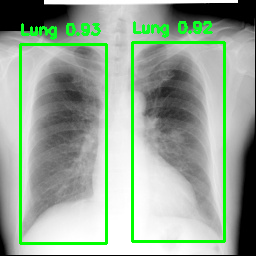


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_89.jpg: 640x640 2 Lungs, 12.0ms
Speed: 3.4ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


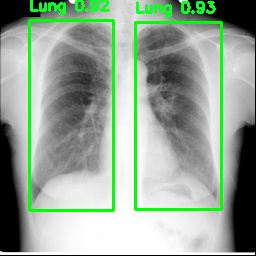


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_90.jpg: 640x640 2 Lungs, 9.6ms
Speed: 2.7ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


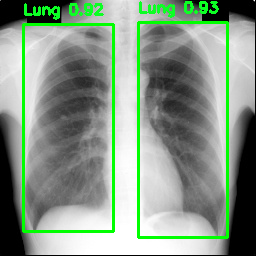


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_91.jpg: 640x640 2 Lungs, 12.5ms
Speed: 2.6ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


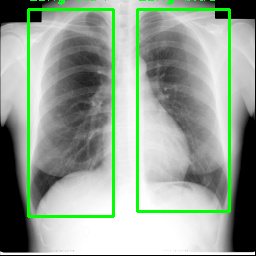


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_92.jpg: 640x640 4 Lungs, 9.1ms
Speed: 2.6ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


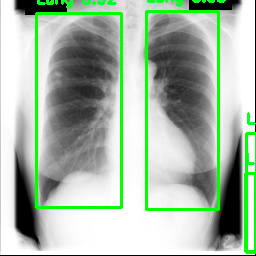


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_93.jpg: 640x640 2 Lungs, 12.5ms
Speed: 2.6ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


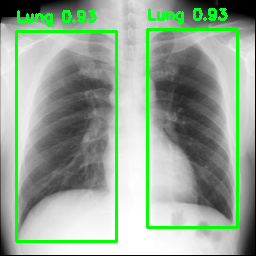


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_94.jpg: 640x640 2 Lungs, 12.8ms
Speed: 2.7ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


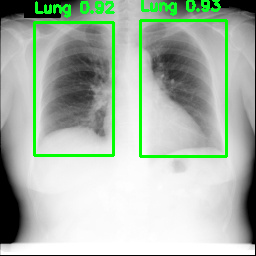


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_95.jpg: 640x640 3 Lungs, 19.1ms
Speed: 3.4ms preprocess, 19.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


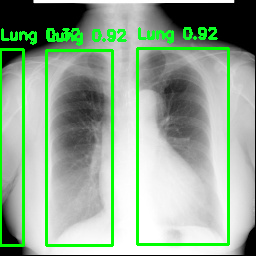


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_96.jpg: 640x640 2 Lungs, 13.8ms
Speed: 2.9ms preprocess, 13.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


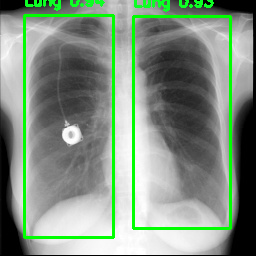


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_97.jpg: 640x640 2 Lungs, 16.4ms
Speed: 2.8ms preprocess, 16.4ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 640)


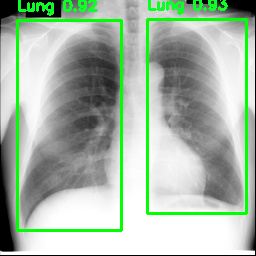


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_98.jpg: 640x640 2 Lungs, 23.3ms
Speed: 3.4ms preprocess, 23.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


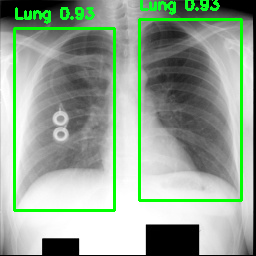


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_99.jpg: 640x640 2 Lungs, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 17.2ms postprocess per image at shape (1, 3, 640, 640)


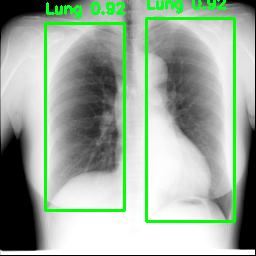


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_100.jpg: 640x640 2 Lungs, 23.5ms
Speed: 2.9ms preprocess, 23.5ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)


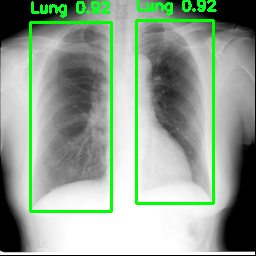


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_101.jpg: 640x640 2 Lungs, 19.8ms
Speed: 9.5ms preprocess, 19.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


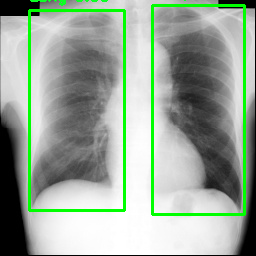


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_102.jpg: 640x640 2 Lungs, 9.4ms
Speed: 4.3ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


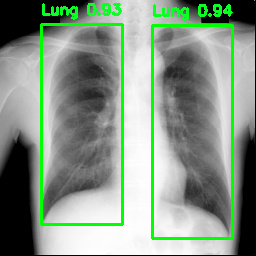


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_103.jpg: 640x640 2 Lungs, 14.0ms
Speed: 2.7ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


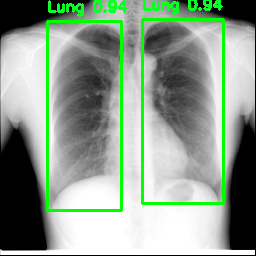


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_104.jpg: 640x640 2 Lungs, 14.2ms
Speed: 5.2ms preprocess, 14.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


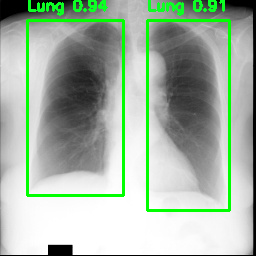


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_105.jpg: 640x640 2 Lungs, 18.0ms
Speed: 2.8ms preprocess, 18.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


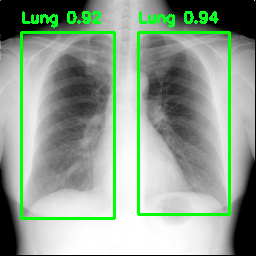


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_106.jpg: 640x640 2 Lungs, 12.1ms
Speed: 2.7ms preprocess, 12.1ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)


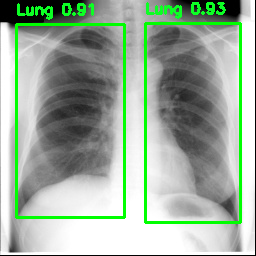


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_107.jpg: 640x640 2 Lungs, 15.1ms
Speed: 6.2ms preprocess, 15.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


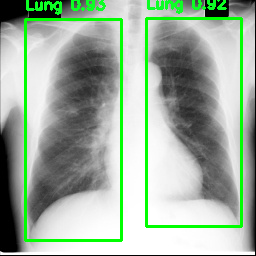


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_108.jpg: 640x640 2 Lungs, 13.9ms
Speed: 6.9ms preprocess, 13.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


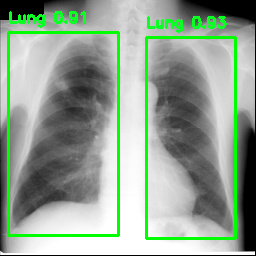


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_109.jpg: 640x640 2 Lungs, 12.0ms
Speed: 5.3ms preprocess, 12.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


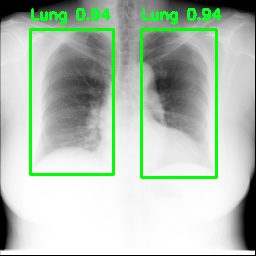


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_110.jpg: 640x640 2 Lungs, 11.4ms
Speed: 3.3ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


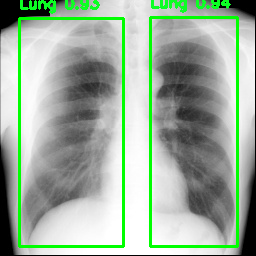


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_111.jpg: 640x640 2 Lungs, 15.6ms
Speed: 2.8ms preprocess, 15.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


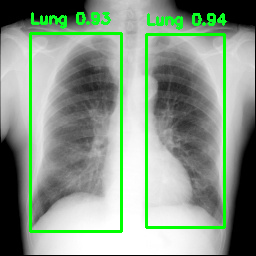


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_112.jpg: 640x640 2 Lungs, 13.1ms
Speed: 2.7ms preprocess, 13.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


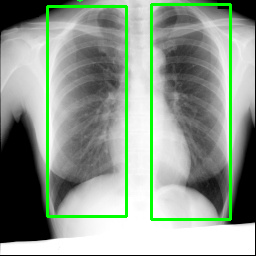


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_113.jpg: 640x640 2 Lungs, 14.4ms
Speed: 2.8ms preprocess, 14.4ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)


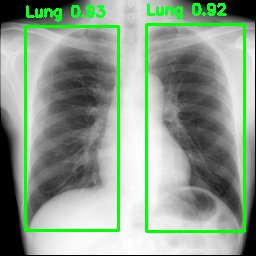


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_114.jpg: 640x640 2 Lungs, 14.1ms
Speed: 2.8ms preprocess, 14.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


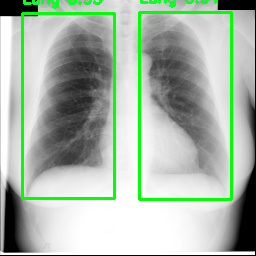


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_115.jpg: 640x640 2 Lungs, 10.6ms
Speed: 2.6ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


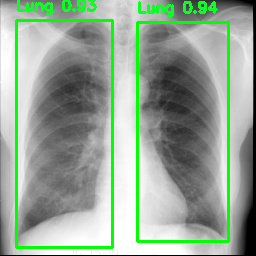


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_116.jpg: 640x640 2 Lungs, 15.7ms
Speed: 2.8ms preprocess, 15.7ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)


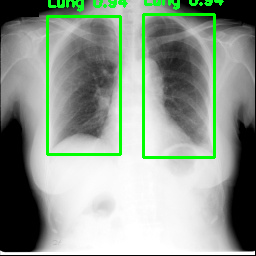


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_117.jpg: 640x640 2 Lungs, 12.8ms
Speed: 2.8ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


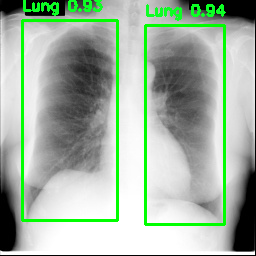


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_118.jpg: 640x640 2 Lungs, 15.7ms
Speed: 2.8ms preprocess, 15.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


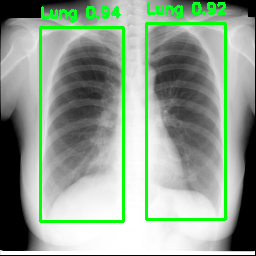


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_119.jpg: 640x640 2 Lungs, 16.0ms
Speed: 2.8ms preprocess, 16.0ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)


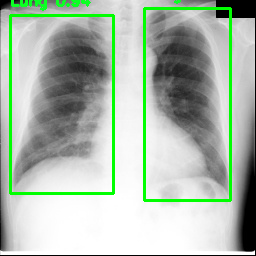


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_120.jpg: 640x640 2 Lungs, 19.7ms
Speed: 3.2ms preprocess, 19.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


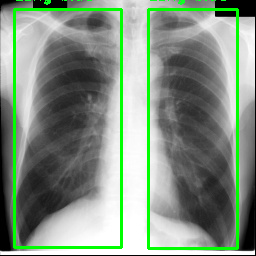


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_121.jpg: 640x640 2 Lungs, 14.5ms
Speed: 3.1ms preprocess, 14.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


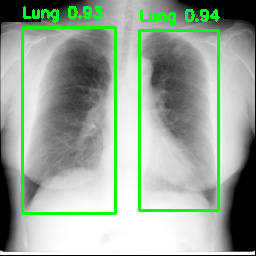


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_122.jpg: 640x640 2 Lungs, 14.6ms
Speed: 2.8ms preprocess, 14.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


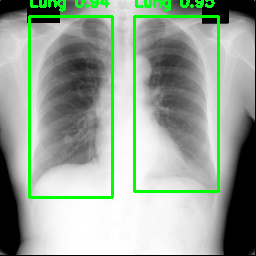

In [ ]:
test_dir = '/content/drive/MyDrive/ColabNotebooks/Yolo8/data/test'
test_images = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.jpg') or f.endswith('.png')]

for img_path in test_images:
    img = cv2.imread(img_path)
    results = trained_model.predict(source=img_path)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    scores = results[0].boxes.conf.cpu().numpy()
    class_names = results[0].boxes.cls.cpu().numpy().astype(int)
    class_ids = results[0].boxes.cls.cpu().numpy()
    class_names = [trained_model.names[cls_id] for cls_id in class_names]
    img = draw_bboxes(img, boxes, scores, class_names, class_ids)
    cv2_imshow(img)

In [ ]:
def load_image(image_path):
    return cv2.imread(image_path)

# Function to load the ground truth bounding boxes
def load_ground_truth_boxes(txt_path, img_shape):
    boxes = []
    with open(txt_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            x_center, y_center, width, height = map(float, parts[1:])
            x_center *= img_shape[1]
            y_center *= img_shape[0]
            width *= img_shape[1]
            height *= img_shape[0]
            x1 = x_center - width / 2
            y1 = y_center - height / 2
            x2 = x_center + width / 2
            y2 = y_center + height / 2
            boxes.append({'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2})
    return boxes

In [ ]:
# Function to compute IoU using the corrected version
def get_iou(bb1, bb2):
    assert bb1['x1'] <= bb1['x2']
    assert bb1['y1'] <= bb1['y2']
    assert bb2['x1'] <= bb2['x2']
    assert bb2['y1'] <= bb2['y2']

    # Determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left + 1) * (y_bottom - y_top + 1)

    # Compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1'] + 1) * (bb1['y2'] - bb1['y1'] + 1)
    bb2_area = (bb2['x2'] - bb2['x1'] + 1) * (bb2['y2'] - bb2['y1'] + 1)

    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
test_dir = '/content/drive/MyDrive/ColabNotebooks/Yolo8/data/test'
test_images = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.jpg') or f.endswith('.png')]

ious = []
pred_boxes_dicts_all = []
gt_boxes_all = []

for image_path in test_images:
    txt_path = image_path.replace('.jpg', '.txt').replace('.png', '.txt')

    # Load the image and ground truth boxes
    image = load_image(image_path)
    img_shape = image.shape
    ground_truth_boxes = load_ground_truth_boxes(txt_path, img_shape)

    # Get predictions from YOLO model
    results = trained_model.predict(source=image_path, save=False, save_txt=False)
    pred_boxes = results[0].boxes.xyxy.cpu().numpy()

    # Convert predicted boxes to the same format
    pred_boxes_dicts = [{'x1': box[0], 'y1': box[1], 'x2': box[2], 'y2': box[3]} for box in pred_boxes]

    print(f"Image: {image_path}")
    print(f"Predicted Boxes: {pred_boxes_dicts}")
    print(f"Ground Truth Boxes: {ground_truth_boxes}")

    pred_boxes_dicts_all.append(pred_boxes_dicts)
    gt_boxes_all.append(ground_truth_boxes)

    # Calculate IoU for each ground truth box
    for gt_box in ground_truth_boxes:
        best_iou = 0
        for pred_box in pred_boxes_dicts:
            iou = get_iou(gt_box, pred_box)
            if iou > best_iou:
                best_iou = iou
        ious.append(best_iou)

print(f"Collected predicted and ground truth boxes for {len(test_images)} images.")

mean_iou = np.mean(ious)
print(f"Mean IoU on the test set: {mean_iou:.4f}")


image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_0.jpg: 640x640 2 Lungs, 22.3ms
Speed: 2.9ms preprocess, 22.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)
Image: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_0.jpg
Predicted Boxes: [{'x1': 44.0675, 'y1': 25.69673, 'x2': 126.19012, 'y2': 241.85728}, {'x1': 151.39542, 'y1': 25.565723, 'x2': 238.64436, 'y2': 243.28113}]
Ground Truth Boxes: [{'x1': 45.0, 'y1': 26.0, 'x2': 124.0, 'y2': 243.0}, {'x1': 155.0, 'y1': 25.0, 'x2': 238.0, 'y2': 245.0}]

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_1.jpg: 640x640 2 Lungs, 11.5ms
Speed: 3.3ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Image: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_1.jpg
Predicted Boxes: [{'x1': 33.96511, 'y1': 24.119629, 'x2': 119.56516, 'y2': 221.9036}, {'x1': 143.11983, 'y1': 27.616583, 'x2': 218.71484, 'y2': 229.64383}]
Ground Truth Boxes:

In [ ]:
f1_scores = []
f1 = torchmetrics.F1Score(task="binary")

for i, image_path in enumerate(tqdm(test_images, desc="Evaluating")):

    print(f"\nProcessing image {i + 1}/{len(test_images)}: {image_path}")
    # Load the image and ground truth mask
    image = cv2.imread(image_path)
    ground_truth_mask = y_test[i]  # Use the corresponding ground truth mask
    print(f"Ground truth mask for image {i + 1} loaded. Shape: {ground_truth_mask.shape}")

    # Get predictions from YOLO model
    results = trained_model.predict(source=image_path, save=False, save_txt=False)
    pred_boxes = results[0].boxes.xyxy.cpu().numpy()
    print(f"Predicted bounding boxes for image {i + 1}: {pred_boxes}")

    # Process each predicted box with SAM
    predictor.set_image(image)
    combined_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

    for box in pred_boxes:
        box = np.array([box[0], box[1], box[2], box[3]])  # Ensure the box is in the correct shape
        masks, _, _ = predictor.predict(box=box[np.newaxis, :], multimask_output=False)
        combined_mask = np.logical_or(combined_mask, masks[0]).astype(np.uint8)
        print(f"Processed box {i + 1}/{len(pred_boxes)} for image {i + 1}")

    pred_mask_tensor = torch.from_numpy(combined_mask)
    mask_gt_tensor = torch.from_numpy(ground_truth_mask)

    f1_score = f1(pred_mask_tensor.flatten(), mask_gt_tensor.flatten())
    f1_scores.append(f1_score.item())
    print(f"F1 score for image {i + 1}: {f1_score.item()}")

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

Evaluating:   0%|          | 0/123 [00:00<?, ?it/s]


Processing image 1/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_0.jpg
Ground truth mask for image 1 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_0.jpg: 640x640 2 Lungs, 11.6ms
Speed: 3.8ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 1: [[     44.068      25.697      126.19      241.86]
 [      151.4      25.566      238.64      243.28]]


/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/prompt_encoder.py:199: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:83.)
  y_embed = grid.cumsum(dim=0) - 0.5
/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/prompt_encoder.py:200: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:83.)
  x_embed = grid.cumsum(dim=1) - 0.5
Evaluating:   1%|          | 1/123 [00:02<05:13,  2.57

Processed box 1/2 for image 1
Processed box 1/2 for image 1
F1 score for image 1: 0.9425970315933228

Processing image 2/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_1.jpg
Ground truth mask for image 2 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_1.jpg: 640x640 2 Lungs, 30.4ms
Speed: 3.0ms preprocess, 30.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 2: [[     33.965       24.12      119.57       221.9]
 [     143.12      27.617      218.71      229.64]]


Evaluating:   2%|▏         | 2/123 [00:05<05:16,  2.61s/it]

Processed box 2/2 for image 2
Processed box 2/2 for image 2
F1 score for image 2: 0.9460620284080505

Processing image 3/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_2.jpg
Ground truth mask for image 3 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_2.jpg: 640x640 2 Lungs, 27.9ms
Speed: 3.1ms preprocess, 27.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 3: [[     31.905     0.62134      114.82      188.94]
 [     138.85      0.8527       224.9      187.68]]
Processed box 3/2 for image 3


Evaluating:   2%|▏         | 3/123 [00:08<05:28,  2.74s/it]

Processed box 3/2 for image 3
F1 score for image 3: 0.9388490319252014

Processing image 4/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_3.jpg
Ground truth mask for image 4 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_3.jpg: 640x640 2 Lungs, 59.5ms
Speed: 14.9ms preprocess, 59.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 4: [[     157.62      23.877      229.78      223.48]
 [     36.364      23.326      131.84       230.6]]


Evaluating:   3%|▎         | 4/123 [00:10<05:21,  2.71s/it]

Processed box 4/2 for image 4
Processed box 4/2 for image 4
F1 score for image 4: 0.8950170278549194

Processing image 5/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_4.jpg
Ground truth mask for image 5 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_4.jpg: 640x640 2 Lungs, 10.8ms
Speed: 2.7ms preprocess, 10.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 5: [[     136.05      36.289      230.02      219.24]
 [     29.041      38.588      113.01      227.61]]


Evaluating:   4%|▍         | 5/123 [00:13<05:09,  2.62s/it]

Processed box 5/2 for image 5
Processed box 5/2 for image 5
F1 score for image 5: 0.9443007111549377

Processing image 6/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_5.jpg
Ground truth mask for image 6 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_5.jpg: 640x640 2 Lungs, 8.8ms
Speed: 2.6ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 6: [[     139.74      20.098      227.19      242.47]
 [     8.8202      19.697      112.76      243.15]]


Evaluating:   5%|▍         | 6/123 [00:15<05:01,  2.57s/it]

Processed box 6/2 for image 6
Processed box 6/2 for image 6
F1 score for image 6: 0.9536314606666565

Processing image 7/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_6.jpg
Ground truth mask for image 7 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_6.jpg: 640x640 2 Lungs, 9.8ms
Speed: 2.2ms preprocess, 9.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 7: [[     30.909      22.942      113.18      227.38]
 [     140.84      23.639      234.78      241.65]]


Evaluating:   6%|▌         | 7/123 [00:18<04:54,  2.54s/it]

Processed box 7/2 for image 7
Processed box 7/2 for image 7
F1 score for image 7: 0.8587912917137146

Processing image 8/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_7.jpg
Ground truth mask for image 8 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_7.jpg: 640x640 2 Lungs, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 8: [[     135.89      20.953      221.84      193.97]
 [     37.983      24.263      114.42      185.46]]


Evaluating:   7%|▋         | 8/123 [00:20<04:48,  2.51s/it]

Processed box 8/2 for image 8
Processed box 8/2 for image 8
F1 score for image 8: 0.9089036583900452

Processing image 9/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_8.jpg
Ground truth mask for image 9 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_8.jpg: 640x640 2 Lungs, 11.6ms
Speed: 2.8ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 9: [[     32.303      17.683      121.02      198.97]
 [     149.31      19.398       243.3      192.29]]


Evaluating:   7%|▋         | 9/123 [00:23<04:44,  2.49s/it]

Processed box 9/2 for image 9
Processed box 9/2 for image 9
F1 score for image 9: 0.9191592335700989

Processing image 10/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_10.jpg
Ground truth mask for image 10 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_10.jpg: 640x640 2 Lungs, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 10: [[     145.84      36.976      251.53      248.76]
 [     17.015      39.432       120.3      246.96]]


Evaluating:   8%|▊         | 10/123 [00:25<04:39,  2.48s/it]

Processed box 10/2 for image 10
Processed box 10/2 for image 10
F1 score for image 10: 0.7580445408821106

Processing image 11/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_9.jpg
Ground truth mask for image 11 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_9.jpg: 640x640 2 Lungs, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 11: [[     144.94      32.015      234.15      203.39]
 [     27.765      32.532      116.25      208.38]]


Evaluating:   9%|▉         | 11/123 [00:27<04:35,  2.46s/it]

Processed box 11/2 for image 11
Processed box 11/2 for image 11
F1 score for image 11: 0.7224904894828796

Processing image 12/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_11.jpg
Ground truth mask for image 12 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_11.jpg: 640x640 2 Lungs, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 12: [[     42.703      18.224      117.11      175.89]
 [     143.34      13.826      226.31      178.42]]


Evaluating:  10%|▉         | 12/123 [00:30<04:31,  2.44s/it]

Processed box 12/2 for image 12
Processed box 12/2 for image 12
F1 score for image 12: 0.9294150471687317

Processing image 13/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_12.jpg
Ground truth mask for image 13 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_12.jpg: 640x640 2 Lungs, 17.3ms
Speed: 2.7ms preprocess, 17.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 13: [[     153.81      24.647      252.87       167.3]
 [     9.8389      24.015      124.16      159.43]]


Evaluating:  11%|█         | 13/123 [00:32<04:26,  2.43s/it]

Processed box 13/2 for image 13
Processed box 13/2 for image 13
F1 score for image 13: 0.9510710835456848

Processing image 14/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_13.jpg
Ground truth mask for image 14 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_13.jpg: 640x640 2 Lungs, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 14: [[     30.181      18.274      116.41      193.98]
 [     138.14       16.27      221.95      214.94]]


Evaluating:  11%|█▏        | 14/123 [00:35<04:21,  2.40s/it]

Processed box 14/2 for image 14
Processed box 14/2 for image 14
F1 score for image 14: 0.9503542184829712

Processing image 15/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_14.jpg
Ground truth mask for image 15 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_14.jpg: 640x640 2 Lungs, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 15: [[         13      22.235       117.4      192.67]
 [     147.59      19.137      242.76      208.57]]


Evaluating:  12%|█▏        | 15/123 [00:37<04:16,  2.38s/it]

Processed box 15/2 for image 15
Processed box 15/2 for image 15
F1 score for image 15: 0.9068471789360046

Processing image 16/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_15.jpg
Ground truth mask for image 16 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_15.jpg: 640x640 2 Lungs, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 16: [[     142.34      28.612      222.95      229.35]
 [     32.497      29.374      121.03      235.38]]


Evaluating:  13%|█▎        | 16/123 [00:39<04:12,  2.36s/it]

Processed box 16/2 for image 16
Processed box 16/2 for image 16
F1 score for image 16: 0.904170572757721

Processing image 17/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_16.jpg
Ground truth mask for image 17 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_16.jpg: 640x640 2 Lungs, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 17: [[     36.769      29.668      117.81      211.65]
 [     136.74      29.002      220.15       218.8]]


Evaluating:  14%|█▍        | 17/123 [00:42<04:08,  2.35s/it]

Processed box 17/2 for image 17
Processed box 17/2 for image 17
F1 score for image 17: 0.840675413608551

Processing image 18/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_17.jpg
Ground truth mask for image 18 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_17.jpg: 640x640 2 Lungs, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 18: [[     42.778      18.709      124.78      205.15]
 [     148.07      18.205      233.92      203.14]]


Evaluating:  15%|█▍        | 18/123 [00:44<04:05,  2.34s/it]

Processed box 18/2 for image 18
Processed box 18/2 for image 18
F1 score for image 18: 0.9398407340049744

Processing image 19/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_18.jpg
Ground truth mask for image 19 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_18.jpg: 640x640 2 Lungs, 10.5ms
Speed: 2.8ms preprocess, 10.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 19: [[     140.76      8.3845      218.91      215.73]
 [     20.914      12.178      114.04       218.6]]


Evaluating:  15%|█▌        | 19/123 [00:46<04:02,  2.34s/it]

Processed box 19/2 for image 19
Processed box 19/2 for image 19
F1 score for image 19: 0.8902705311775208

Processing image 20/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_19.jpg
Ground truth mask for image 20 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_19.jpg: 640x640 2 Lungs, 10.9ms
Speed: 3.0ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 20: [[     135.85      25.182      225.91      223.53]
 [     22.622      27.185      114.69      230.51]]


Evaluating:  16%|█▋        | 20/123 [00:49<03:59,  2.33s/it]

Processed box 20/2 for image 20
Processed box 20/2 for image 20
F1 score for image 20: 0.8843556642532349

Processing image 21/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_20.jpg
Ground truth mask for image 21 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_20.jpg: 640x640 2 Lungs, 11.4ms
Speed: 2.7ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 21: [[     146.52      22.813      236.64      222.42]
 [     2.4418      22.196      118.92      205.54]]


Evaluating:  17%|█▋        | 21/123 [00:51<03:57,  2.32s/it]

Processed box 21/2 for image 21
Processed box 21/2 for image 21
F1 score for image 21: 0.9539763331413269

Processing image 22/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_21.jpg
Ground truth mask for image 22 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_21.jpg: 640x640 2 Lungs, 13.5ms
Speed: 2.8ms preprocess, 13.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 22: [[     146.62       12.63      224.05      203.13]
 [     42.688      14.651       122.9      212.44]]


Evaluating:  18%|█▊        | 22/123 [00:53<03:53,  2.32s/it]

Processed box 22/2 for image 22
Processed box 22/2 for image 22
F1 score for image 22: 0.9483126997947693

Processing image 23/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_22.jpg
Ground truth mask for image 23 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_22.jpg: 640x640 2 Lungs, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 23: [[     137.21      26.163      231.43      222.36]
 [     8.9035      29.106      107.57      224.98]]


Evaluating:  19%|█▊        | 23/123 [00:55<03:50,  2.30s/it]

Processed box 23/2 for image 23
Processed box 23/2 for image 23
F1 score for image 23: 0.9212037920951843

Processing image 24/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_23.jpg
Ground truth mask for image 24 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_23.jpg: 640x640 2 Lungs, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 24: [[     32.263      3.9618      118.39      181.69]
 [     142.34      5.7966      216.05      183.06]]


Evaluating:  20%|█▉        | 24/123 [00:58<03:46,  2.29s/it]

Processed box 24/2 for image 24
Processed box 24/2 for image 24
F1 score for image 24: 0.87092125415802

Processing image 25/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_24.jpg
Ground truth mask for image 25 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_24.jpg: 640x640 2 Lungs, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 25: [[     29.052      8.5673      114.36      228.06]
 [     138.83       11.75       215.3      229.54]]


Evaluating:  20%|██        | 25/123 [01:00<03:43,  2.28s/it]

Processed box 25/2 for image 25
Processed box 25/2 for image 25
F1 score for image 25: 0.9511167407035828

Processing image 26/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_25.jpg
Ground truth mask for image 26 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_25.jpg: 640x640 2 Lungs, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 26: [[      27.73      18.245      116.93      237.13]
 [     144.11      17.488      241.47      226.05]]


Evaluating:  21%|██        | 26/123 [01:02<03:41,  2.28s/it]

Processed box 26/2 for image 26
Processed box 26/2 for image 26
F1 score for image 26: 0.9464235901832581

Processing image 27/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_26.jpg
Ground truth mask for image 27 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_26.jpg: 640x640 2 Lungs, 8.7ms
Speed: 3.0ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 27: [[     17.837      18.939      116.73      214.46]
 [     143.95      18.506      236.58      220.06]]


Evaluating:  22%|██▏       | 27/123 [01:05<03:40,  2.30s/it]

Processed box 27/2 for image 27
Processed box 27/2 for image 27
F1 score for image 27: 0.9409570693969727

Processing image 28/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_27.jpg
Ground truth mask for image 28 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_27.jpg: 640x640 2 Lungs, 10.9ms
Speed: 3.0ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 28: [[      41.82      26.582      117.42      215.73]
 [     141.24      23.258      226.13      222.84]]


Evaluating:  23%|██▎       | 28/123 [01:07<03:38,  2.30s/it]

Processed box 28/2 for image 28
Processed box 28/2 for image 28
F1 score for image 28: 0.9538083672523499

Processing image 29/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_28.jpg
Ground truth mask for image 29 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_28.jpg: 640x640 2 Lungs, 13.6ms
Speed: 2.7ms preprocess, 13.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 29: [[     38.885      14.119      128.69      217.23]
 [     154.22       16.52      232.62      233.39]]
Processed box 29/2 for image 29


Evaluating:  24%|██▎       | 29/123 [01:10<03:48,  2.43s/it]

Processed box 29/2 for image 29
F1 score for image 29: 0.9526718854904175

Processing image 30/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_29.jpg
Ground truth mask for image 30 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_29.jpg: 640x640 2 Lungs, 17.0ms
Speed: 3.0ms preprocess, 17.0ms inference, 23.0ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 30: [[     148.86      26.132      242.59      240.29]
 [     27.189      26.496      124.12      224.54]]


Evaluating:  24%|██▍       | 30/123 [01:12<03:51,  2.49s/it]

Processed box 30/2 for image 30
Processed box 30/2 for image 30
F1 score for image 30: 0.9386283159255981

Processing image 31/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_30.jpg
Ground truth mask for image 31 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_30.jpg: 640x640 2 Lungs, 11.6ms
Speed: 2.9ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 31: [[     27.429      15.741      125.62      199.64]
 [     148.21      11.525      232.98      211.31]]


Evaluating:  25%|██▌       | 31/123 [01:14<03:43,  2.43s/it]

Processed box 31/2 for image 31
Processed box 31/2 for image 31
F1 score for image 31: 0.9307751059532166

Processing image 32/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_31.jpg
Ground truth mask for image 32 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_31.jpg: 640x640 2 Lungs, 10.5ms
Speed: 3.7ms preprocess, 10.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 32: [[     134.28      18.895      207.21      216.82]
 [     33.722      19.977      107.77      208.59]]


Evaluating:  26%|██▌       | 32/123 [01:17<03:38,  2.40s/it]

Processed box 32/2 for image 32
Processed box 32/2 for image 32
F1 score for image 32: 0.9414103031158447

Processing image 33/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_32.jpg
Ground truth mask for image 33 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_32.jpg: 640x640 2 Lungs, 10.1ms
Speed: 2.8ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 33: [[     23.131      2.0294      118.56      180.64]
 [     140.34      2.7787       229.6       170.1]]


Evaluating:  27%|██▋       | 33/123 [01:19<03:33,  2.38s/it]

Processed box 33/2 for image 33
Processed box 33/2 for image 33
F1 score for image 33: 0.9302796125411987

Processing image 34/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_33.jpg
Ground truth mask for image 34 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_33.jpg: 640x640 2 Lungs, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 34: [[     142.02      28.827      215.31      217.18]
 [     53.555      30.008       118.6      201.69]]


Evaluating:  28%|██▊       | 34/123 [01:21<03:29,  2.35s/it]

Processed box 34/2 for image 34
Processed box 34/2 for image 34
F1 score for image 34: 0.8992709517478943

Processing image 35/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_34.jpg
Ground truth mask for image 35 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_34.jpg: 640x640 2 Lungs, 14.1ms
Speed: 2.9ms preprocess, 14.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 35: [[     146.59      16.617      238.63      182.51]
 [     40.326      20.348      124.27      185.41]]


Evaluating:  28%|██▊       | 35/123 [01:24<03:26,  2.35s/it]

Processed box 35/2 for image 35
Processed box 35/2 for image 35
F1 score for image 35: 0.930091381072998

Processing image 36/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_35.jpg
Ground truth mask for image 36 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_35.jpg: 640x640 2 Lungs, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 36: [[     1.9882      17.424         114      213.47]
 [     140.53      15.504      250.66      216.47]]


Evaluating:  29%|██▉       | 36/123 [01:26<03:24,  2.35s/it]

Processed box 36/2 for image 36
Processed box 36/2 for image 36
F1 score for image 36: 0.9484631419181824

Processing image 37/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_36.jpg
Ground truth mask for image 37 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_36.jpg: 640x640 2 Lungs, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 37: [[     141.93      31.383      224.67      190.62]
 [     40.389      30.606      113.11      206.29]]


Evaluating:  30%|███       | 37/123 [01:28<03:22,  2.35s/it]

Processed box 37/2 for image 37
Processed box 37/2 for image 37
F1 score for image 37: 0.8049992322921753

Processing image 38/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_37.jpg
Ground truth mask for image 38 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_37.jpg: 640x640 2 Lungs, 14.0ms
Speed: 3.2ms preprocess, 14.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 38: [[     17.247      16.521      116.61      247.24]
 [     146.86      19.136      241.04      237.15]]


Evaluating:  31%|███       | 38/123 [01:31<03:20,  2.36s/it]

Processed box 38/2 for image 38
Processed box 38/2 for image 38
F1 score for image 38: 0.8668399453163147

Processing image 39/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_38.jpg
Ground truth mask for image 39 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_38.jpg: 640x640 2 Lungs, 11.1ms
Speed: 2.8ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 39: [[     17.914      32.195      105.27      242.89]
 [     133.24      32.311      222.76      240.62]]


Evaluating:  32%|███▏      | 39/123 [01:33<03:18,  2.36s/it]

Processed box 39/2 for image 39
Processed box 39/2 for image 39
F1 score for image 39: 0.9531576633453369

Processing image 40/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_39.jpg
Ground truth mask for image 40 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_39.jpg: 640x640 2 Lungs, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 40: [[     144.95      25.876      242.62       247.8]
 [     9.9279      25.496      116.75      244.73]]


Evaluating:  33%|███▎      | 40/123 [01:36<03:15,  2.36s/it]

Processed box 40/2 for image 40
Processed box 40/2 for image 40
F1 score for image 40: 0.9460563063621521

Processing image 41/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_40.jpg
Ground truth mask for image 41 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_40.jpg: 640x640 2 Lungs, 9.1ms
Speed: 2.1ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 41: [[     142.84      9.8192      228.04      227.02]
 [     30.997      11.301      115.17      227.62]]


Evaluating:  33%|███▎      | 41/123 [01:38<03:13,  2.36s/it]

Processed box 41/2 for image 41
Processed box 41/2 for image 41
F1 score for image 41: 0.936290442943573

Processing image 42/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_41.jpg
Ground truth mask for image 42 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_41.jpg: 640x640 2 Lungs, 12.7ms
Speed: 2.2ms preprocess, 12.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 42: [[     145.43      41.405      226.28      230.78]
 [     18.302      40.548      115.76      231.62]]


Evaluating:  34%|███▍      | 42/123 [01:40<03:11,  2.36s/it]

Processed box 42/2 for image 42
Processed box 42/2 for image 42
F1 score for image 42: 0.9218151569366455

Processing image 43/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_42.jpg
Ground truth mask for image 43 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_42.jpg: 640x640 2 Lungs, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 43: [[     35.246      20.527      118.97       213.5]
 [     141.23      22.242      221.74      212.04]]


Evaluating:  35%|███▍      | 43/123 [01:43<03:09,  2.37s/it]

Processed box 43/2 for image 43
Processed box 43/2 for image 43
F1 score for image 43: 0.9455238580703735

Processing image 44/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_43.jpg
Ground truth mask for image 44 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_43.jpg: 640x640 2 Lungs, 9.7ms
Speed: 4.2ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 44: [[      139.5      21.748      223.27      231.88]
 [     34.746      20.363      114.35      223.61]]


Evaluating:  36%|███▌      | 44/123 [01:45<03:07,  2.38s/it]

Processed box 44/2 for image 44
Processed box 44/2 for image 44
F1 score for image 44: 0.9404346942901611

Processing image 45/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_44.jpg
Ground truth mask for image 45 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_44.jpg: 640x640 2 Lungs, 12.5ms
Speed: 6.4ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 45: [[     32.106      25.728      129.27      235.51]
 [        158      24.832      245.16       228.8]]


Evaluating:  37%|███▋      | 45/123 [01:47<03:06,  2.38s/it]

Processed box 45/2 for image 45
Processed box 45/2 for image 45
F1 score for image 45: 0.9336891174316406

Processing image 46/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_45.jpg
Ground truth mask for image 46 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_45.jpg: 640x640 2 Lungs, 11.6ms
Speed: 2.7ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 46: [[     153.82      27.622      239.82      228.84]
 [     39.947      30.832      128.66      232.23]]


Evaluating:  37%|███▋      | 46/123 [01:50<03:03,  2.39s/it]

Processed box 46/2 for image 46
Processed box 46/2 for image 46
F1 score for image 46: 0.9385782480239868

Processing image 47/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_46.jpg
Ground truth mask for image 47 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_46.jpg: 640x640 2 Lungs, 11.3ms
Speed: 3.3ms preprocess, 11.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 47: [[     141.56      16.744      236.49      225.92]
 [     15.672      16.107      115.06      226.91]]


Evaluating:  38%|███▊      | 47/123 [01:52<03:01,  2.39s/it]

Processed box 47/2 for image 47
Processed box 47/2 for image 47
F1 score for image 47: 0.929126501083374

Processing image 48/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_47.jpg
Ground truth mask for image 48 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_47.jpg: 640x640 2 Lungs, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 48: [[     21.012      30.637      121.36      237.71]
 [     150.34      30.414      245.63       240.8]]


Evaluating:  39%|███▉      | 48/123 [01:55<02:58,  2.38s/it]

Processed box 48/2 for image 48
Processed box 48/2 for image 48
F1 score for image 48: 0.94159996509552

Processing image 49/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_48.jpg
Ground truth mask for image 49 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_48.jpg: 640x640 2 Lungs, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 49: [[     126.39      21.399       239.3       216.9]
 [     7.4532      21.769      103.64      224.18]]


Evaluating:  40%|███▉      | 49/123 [01:57<02:55,  2.37s/it]

Processed box 49/2 for image 49
Processed box 49/2 for image 49
F1 score for image 49: 0.9428701400756836

Processing image 50/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_49.jpg
Ground truth mask for image 50 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_49.jpg: 640x640 2 Lungs, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 50: [[     28.082      13.521      110.15      237.23]
 [     135.36      13.627      223.17      238.82]]


Evaluating:  41%|████      | 50/123 [01:59<02:52,  2.37s/it]

Processed box 50/2 for image 50
Processed box 50/2 for image 50
F1 score for image 50: 0.9297387599945068

Processing image 51/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_50.jpg
Ground truth mask for image 51 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_50.jpg: 640x640 2 Lungs, 8.4ms
Speed: 3.2ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 51: [[     140.32      27.216       226.9      205.74]
 [     21.292      28.355      113.81      194.21]]


Evaluating:  41%|████▏     | 51/123 [02:02<02:50,  2.37s/it]

Processed box 51/2 for image 51
Processed box 51/2 for image 51
F1 score for image 51: 0.9149643778800964

Processing image 52/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_51.jpg
Ground truth mask for image 52 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_51.jpg: 640x640 2 Lungs, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 52: [[     15.942      18.293       109.8      242.04]
 [     137.07      19.197      236.73       224.5]]


Evaluating:  42%|████▏     | 52/123 [02:04<02:48,  2.38s/it]

Processed box 52/2 for image 52
Processed box 52/2 for image 52
F1 score for image 52: 0.8740749359130859

Processing image 53/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_52.jpg
Ground truth mask for image 53 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_52.jpg: 640x640 2 Lungs, 11.4ms
Speed: 3.0ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 53: [[     32.515      24.942      120.31      211.24]
 [     146.05      23.565      227.65      221.61]]


Evaluating:  43%|████▎     | 53/123 [02:06<02:46,  2.38s/it]

Processed box 53/2 for image 53
Processed box 53/2 for image 53
F1 score for image 53: 0.9475085139274597

Processing image 54/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_53.jpg
Ground truth mask for image 54 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_53.jpg: 640x640 2 Lungs, 21.4ms
Speed: 3.2ms preprocess, 21.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 54: [[     148.61      27.634      231.24      198.78]
 [     19.865      26.164      119.58      216.93]]


Evaluating:  44%|████▍     | 54/123 [02:09<02:44,  2.39s/it]

Processed box 54/2 for image 54
Processed box 54/2 for image 54
F1 score for image 54: 0.9540826678276062

Processing image 55/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_54.jpg
Ground truth mask for image 55 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_54.jpg: 640x640 2 Lungs, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 55: [[     28.779      16.877      120.96      217.57]
 [     140.94      12.424         239      218.34]]


Evaluating:  45%|████▍     | 55/123 [02:11<02:41,  2.38s/it]

Processed box 55/2 for image 55
Processed box 55/2 for image 55
F1 score for image 55: 0.8348000645637512

Processing image 56/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_55.jpg
Ground truth mask for image 56 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_55.jpg: 640x640 2 Lungs, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 56: [[     138.07      28.461      252.11       219.3]
 [      2.598      23.005      110.78      228.51]]


Evaluating:  46%|████▌     | 56/123 [02:14<02:38,  2.36s/it]

Processed box 56/2 for image 56
Processed box 56/2 for image 56
F1 score for image 56: 0.9437954425811768

Processing image 57/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_56.jpg
Ground truth mask for image 57 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_56.jpg: 640x640 2 Lungs, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 57: [[     37.058      9.5539      116.28      220.74]
 [      141.4      9.9633      218.73       216.4]]


Evaluating:  46%|████▋     | 57/123 [02:16<02:35,  2.35s/it]

Processed box 57/2 for image 57
Processed box 57/2 for image 57
F1 score for image 57: 0.9330293536186218

Processing image 58/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_57.jpg
Ground truth mask for image 58 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_57.jpg: 640x640 2 Lungs, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 58: [[     145.48      7.4425      227.85      179.98]
 [     42.337       8.482      121.33      173.14]]


Evaluating:  47%|████▋     | 58/123 [02:18<02:32,  2.34s/it]

Processed box 58/2 for image 58
Processed box 58/2 for image 58
F1 score for image 58: 0.9300596714019775

Processing image 59/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_58.jpg
Ground truth mask for image 59 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_58.jpg: 640x640 2 Lungs, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 59: [[     135.24      21.973      222.71      192.45]
 [     39.893      24.226      116.79      200.29]]


Evaluating:  48%|████▊     | 59/123 [02:21<02:29,  2.34s/it]

Processed box 59/2 for image 59
Processed box 59/2 for image 59
F1 score for image 59: 0.938383162021637

Processing image 60/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_59.jpg
Ground truth mask for image 60 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_59.jpg: 640x640 2 Lungs, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 60: [[     145.77      13.349      231.88       176.6]
 [      36.55      15.219       122.8      169.99]]


Evaluating:  49%|████▉     | 60/123 [02:23<02:27,  2.34s/it]

Processed box 60/2 for image 60
Processed box 60/2 for image 60
F1 score for image 60: 0.9103905558586121

Processing image 61/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_60.jpg
Ground truth mask for image 61 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_60.jpg: 640x640 2 Lungs, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 61: [[     37.351      23.616      123.36      224.74]
 [     148.02      22.754      241.38      225.42]]


Evaluating:  50%|████▉     | 61/123 [02:25<02:25,  2.35s/it]

Processed box 61/2 for image 61
Processed box 61/2 for image 61
F1 score for image 61: 0.9072311520576477

Processing image 62/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_61.jpg
Ground truth mask for image 62 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_61.jpg: 640x640 2 Lungs, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 62: [[     140.97      27.883      227.62      214.02]
 [     24.175      24.786      117.12      207.84]]


Evaluating:  50%|█████     | 62/123 [02:28<02:22,  2.34s/it]

Processed box 62/2 for image 62
Processed box 62/2 for image 62
F1 score for image 62: 0.9519217014312744

Processing image 63/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_62.jpg
Ground truth mask for image 63 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_62.jpg: 640x640 2 Lungs, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 63: [[     12.354      25.497      112.67      243.76]
 [      141.1      25.029      239.24      241.09]]


Evaluating:  51%|█████     | 63/123 [02:30<02:19,  2.33s/it]

Processed box 63/2 for image 63
Processed box 63/2 for image 63
F1 score for image 63: 0.9293986558914185

Processing image 64/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_63.jpg
Ground truth mask for image 64 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_63.jpg: 640x640 2 Lungs, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 64: [[     33.539      21.186      127.47      211.74]
 [      148.1      20.841      230.01      212.17]]


Evaluating:  52%|█████▏    | 64/123 [02:32<02:17,  2.33s/it]

Processed box 64/2 for image 64
Processed box 64/2 for image 64
F1 score for image 64: 0.9209545850753784

Processing image 65/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_64.jpg
Ground truth mask for image 65 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_64.jpg: 640x640 2 Lungs, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 65: [[     138.42      23.473      230.29      234.54]
 [     13.532      21.768      117.73      243.41]]


Evaluating:  53%|█████▎    | 65/123 [02:35<02:14,  2.32s/it]

Processed box 65/2 for image 65
Processed box 65/2 for image 65
F1 score for image 65: 0.9466758370399475

Processing image 66/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_65.jpg
Ground truth mask for image 66 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_65.jpg: 640x640 2 Lungs, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 66: [[     43.094      34.645      124.26      198.36]
 [     148.82      34.051      229.03      219.47]]


Evaluating:  54%|█████▎    | 66/123 [02:37<02:12,  2.32s/it]

Processed box 66/2 for image 66
Processed box 66/2 for image 66
F1 score for image 66: 0.8609765768051147

Processing image 67/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_66.jpg
Ground truth mask for image 67 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_66.jpg: 640x640 2 Lungs, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 67: [[     23.813      18.165      111.63      186.39]
 [     133.23      17.441       215.9      183.48]]


Evaluating:  54%|█████▍    | 67/123 [02:39<02:09,  2.32s/it]

Processed box 67/2 for image 67
Processed box 67/2 for image 67
F1 score for image 67: 0.912632167339325

Processing image 68/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_67.jpg
Ground truth mask for image 68 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_67.jpg: 640x640 2 Lungs, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 68: [[     30.555      23.155      119.08      194.76]
 [     141.54      24.993      224.26      200.38]]


Evaluating:  55%|█████▌    | 68/123 [02:41<02:07,  2.33s/it]

Processed box 68/2 for image 68
Processed box 68/2 for image 68
F1 score for image 68: 0.9611002206802368

Processing image 69/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_68.jpg
Ground truth mask for image 69 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_68.jpg: 640x640 2 Lungs, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 69: [[     146.41      24.784       230.3      202.74]
 [     31.906      25.484      125.03      198.01]]


Evaluating:  56%|█████▌    | 69/123 [02:44<02:06,  2.34s/it]

Processed box 69/2 for image 69
Processed box 69/2 for image 69
F1 score for image 69: 0.9515027403831482

Processing image 70/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_69.jpg
Ground truth mask for image 70 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_69.jpg: 640x640 2 Lungs, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 70: [[     140.96      15.815      222.33      209.22]
 [     34.832       12.85      120.18      204.64]]


Evaluating:  57%|█████▋    | 70/123 [02:46<02:04,  2.35s/it]

Processed box 70/2 for image 70
Processed box 70/2 for image 70
F1 score for image 70: 0.9213701486587524

Processing image 71/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_70.jpg
Ground truth mask for image 71 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_70.jpg: 640x640 2 Lungs, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 71: [[     146.74      16.343      230.21      210.83]
 [     33.432      17.708      124.95      210.91]]


Evaluating:  58%|█████▊    | 71/123 [02:49<02:01,  2.34s/it]

Processed box 71/2 for image 71
Processed box 71/2 for image 71
F1 score for image 71: 0.9444057941436768

Processing image 72/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_71.jpg
Ground truth mask for image 72 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_71.jpg: 640x640 2 Lungs, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 72: [[     14.678      15.639      120.42      215.78]
 [     148.86      13.219      250.01      221.53]]


Evaluating:  59%|█████▊    | 72/123 [02:51<01:58,  2.33s/it]

Processed box 72/2 for image 72
Processed box 72/2 for image 72
F1 score for image 72: 0.9480118751525879

Processing image 73/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_72.jpg
Ground truth mask for image 73 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_72.jpg: 640x640 2 Lungs, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 73: [[     148.06      22.459      242.35      247.22]
 [     23.335      18.013      119.94      244.81]]


Evaluating:  59%|█████▉    | 73/123 [02:53<01:56,  2.33s/it]

Processed box 73/2 for image 73
Processed box 73/2 for image 73
F1 score for image 73: 0.9409029483795166

Processing image 74/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_74.jpg
Ground truth mask for image 74 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_74.jpg: 640x640 2 Lungs, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 74: [[     147.25      13.031      236.27      246.21]
 [     25.978      15.552      124.97      243.22]]


Evaluating:  60%|██████    | 74/123 [02:56<01:53,  2.33s/it]

Processed box 74/2 for image 74
Processed box 74/2 for image 74
F1 score for image 74: 0.6860584020614624

Processing image 75/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_73.jpg
Ground truth mask for image 75 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_73.jpg: 640x640 2 Lungs, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 75: [[     143.81      21.759      250.25      218.85]
 [     7.9843      24.784      117.67       229.2]]


Evaluating:  61%|██████    | 75/123 [02:58<01:51,  2.33s/it]

Processed box 75/2 for image 75
Processed box 75/2 for image 75
F1 score for image 75: 0.7986986041069031

Processing image 76/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_75.jpg
Ground truth mask for image 76 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_75.jpg: 640x640 2 Lungs, 8.5ms
Speed: 2.7ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 76: [[      26.81      21.448      126.76      219.86]
 [     154.92      16.065      249.39         217]]


Evaluating:  62%|██████▏   | 76/123 [03:00<01:49,  2.34s/it]

Processed box 76/2 for image 76
Processed box 76/2 for image 76
F1 score for image 76: 0.9358341097831726

Processing image 77/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_76.jpg
Ground truth mask for image 77 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_76.jpg: 640x640 2 Lungs, 10.1ms
Speed: 2.7ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 77: [[     17.234      18.892      119.06      248.44]
 [     146.01      14.873      240.36      250.81]]


Evaluating:  63%|██████▎   | 77/123 [03:03<01:47,  2.34s/it]

Processed box 77/2 for image 77
Processed box 77/2 for image 77
F1 score for image 77: 0.9421814680099487

Processing image 78/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_77.jpg
Ground truth mask for image 78 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_77.jpg: 640x640 2 Lungs, 13.8ms
Speed: 2.8ms preprocess, 13.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 78: [[     25.322      33.599      119.07      242.58]
 [     147.69      30.891       240.1      226.45]]


Evaluating:  63%|██████▎   | 78/123 [03:05<01:45,  2.35s/it]

Processed box 78/2 for image 78
Processed box 78/2 for image 78
F1 score for image 78: 0.8967158198356628

Processing image 79/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_78.jpg
Ground truth mask for image 79 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_78.jpg: 640x640 2 Lungs, 10.6ms
Speed: 2.8ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 79: [[     34.919      16.444       114.7      204.66]
 [     139.63      14.842      230.04      204.59]]


Evaluating:  64%|██████▍   | 79/123 [03:07<01:43,  2.35s/it]

Processed box 79/2 for image 79
Processed box 79/2 for image 79
F1 score for image 79: 0.9347372055053711

Processing image 80/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_79.jpg
Ground truth mask for image 80 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_79.jpg: 640x640 2 Lungs, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 80: [[     7.5961        26.3      114.89      228.27]
 [     140.42      25.343      228.03      240.13]]


Evaluating:  65%|██████▌   | 80/123 [03:10<01:40,  2.34s/it]

Processed box 80/2 for image 80
Processed box 80/2 for image 80
F1 score for image 80: 0.9341065287590027

Processing image 81/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_80.jpg
Ground truth mask for image 81 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_80.jpg: 640x640 2 Lungs, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 81: [[     148.34      19.469      222.58      215.78]
 [     49.246      21.853      126.17      215.56]]


Evaluating:  66%|██████▌   | 81/123 [03:12<01:38,  2.34s/it]

Processed box 81/2 for image 81
Processed box 81/2 for image 81
F1 score for image 81: 0.9357503652572632

Processing image 82/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_81.jpg
Ground truth mask for image 82 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_81.jpg: 640x640 2 Lungs, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 82: [[     35.132      10.638      119.19      202.51]
 [     143.44      9.2649       225.8       199.3]]


Evaluating:  67%|██████▋   | 82/123 [03:14<01:35,  2.33s/it]

Processed box 82/2 for image 82
Processed box 82/2 for image 82
F1 score for image 82: 0.9384886622428894

Processing image 83/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_82.jpg
Ground truth mask for image 83 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_82.jpg: 640x640 2 Lungs, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 83: [[     147.47      13.767      248.35       227.6]
 [     25.595      18.001      124.36      217.95]]


Evaluating:  67%|██████▋   | 83/123 [03:17<01:33,  2.34s/it]

Processed box 83/2 for image 83
Processed box 83/2 for image 83
F1 score for image 83: 0.9454042911529541

Processing image 84/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_83.jpg
Ground truth mask for image 84 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_83.jpg: 640x640 2 Lungs, 14.1ms
Speed: 5.9ms preprocess, 14.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 84: [[     48.551      15.873       116.8       209.8]
 [     138.22       7.919      224.29      210.73]]


Evaluating:  68%|██████▊   | 84/123 [03:19<01:31,  2.34s/it]

Processed box 84/2 for image 84
Processed box 84/2 for image 84
F1 score for image 84: 0.8626973032951355

Processing image 85/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_84.jpg
Ground truth mask for image 85 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_84.jpg: 640x640 2 Lungs, 12.5ms
Speed: 3.1ms preprocess, 12.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 85: [[     134.59      30.089      221.76      192.98]
 [     22.658       27.08       112.7       195.2]]


Evaluating:  69%|██████▉   | 85/123 [03:21<01:29,  2.36s/it]

Processed box 85/2 for image 85
Processed box 85/2 for image 85
F1 score for image 85: 0.9602581858634949

Processing image 86/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_85.jpg
Ground truth mask for image 86 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_85.jpg: 640x640 2 Lungs, 16.7ms
Speed: 3.1ms preprocess, 16.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 86: [[     134.18      17.039      221.35      234.54]
 [     9.8211      16.627      108.78      239.11]]


Evaluating:  70%|██████▉   | 86/123 [03:24<01:27,  2.37s/it]

Processed box 86/2 for image 86
Processed box 86/2 for image 86
F1 score for image 86: 0.9499812126159668

Processing image 87/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_86.jpg
Ground truth mask for image 87 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_86.jpg: 640x640 2 Lungs, 21.1ms
Speed: 2.8ms preprocess, 21.1ms inference, 8.8ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 87: [[     26.251      16.593      116.27      227.85]
 [     140.94      15.001       240.9      216.71]]


Evaluating:  71%|███████   | 87/123 [03:26<01:25,  2.38s/it]

Processed box 87/2 for image 87
Processed box 87/2 for image 87
F1 score for image 87: 0.9366432428359985

Processing image 88/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_87.jpg
Ground truth mask for image 88 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_87.jpg: 640x640 2 Lungs, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 88: [[     152.78      11.969      249.14      231.72]
 [     26.943      13.151      121.28      209.66]]


Evaluating:  72%|███████▏  | 88/123 [03:28<01:22,  2.36s/it]

Processed box 88/2 for image 88
Processed box 88/2 for image 88
F1 score for image 88: 0.9377136826515198

Processing image 89/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_88.jpg
Ground truth mask for image 89 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_88.jpg: 640x640 2 Lungs, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 89: [[     20.526      44.515      106.12      243.09]
 [     132.83       42.46      224.95      241.03]]


Evaluating:  72%|███████▏  | 89/123 [03:31<01:20,  2.35s/it]

Processed box 89/2 for image 89
Processed box 89/2 for image 89
F1 score for image 89: 0.9392030239105225

Processing image 90/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_89.jpg
Ground truth mask for image 90 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_89.jpg: 640x640 2 Lungs, 9.4ms
Speed: 2.6ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 90: [[      135.6      22.058      221.83      209.15]
 [     29.203      20.825      113.23      210.34]]


Evaluating:  73%|███████▎  | 90/123 [03:33<01:17,  2.35s/it]

Processed box 90/2 for image 90
Processed box 90/2 for image 90
F1 score for image 90: 0.9383795857429504

Processing image 91/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_90.jpg
Ground truth mask for image 91 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_90.jpg: 640x640 2 Lungs, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 91: [[     138.22       22.12       227.4      237.67]
 [     23.478      24.495      113.56      231.45]]


Evaluating:  74%|███████▍  | 91/123 [03:35<01:15,  2.35s/it]

Processed box 91/2 for image 91
Processed box 91/2 for image 91
F1 score for image 91: 0.9072234034538269

Processing image 92/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_91.jpg
Ground truth mask for image 92 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_91.jpg: 640x640 2 Lungs, 14.7ms
Speed: 2.8ms preprocess, 14.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 92: [[     28.855      9.2366       113.7      216.25]
 [     137.95      9.6586      229.25      211.45]]


Evaluating:  75%|███████▍  | 92/123 [03:38<01:13,  2.36s/it]

Processed box 92/2 for image 92
Processed box 92/2 for image 92
F1 score for image 92: 0.9495377540588379

Processing image 93/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_92.jpg
Ground truth mask for image 93 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_92.jpg: 640x640 4 Lungs, 11.6ms
Speed: 2.9ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 93: [[     146.09      11.124      218.72      209.63]
 [     36.904      13.745      121.68      207.32]
 [     245.91      173.41      255.81      251.07]
 [     246.63      133.26         256      252.37]]


Evaluating:  76%|███████▌  | 93/123 [03:40<01:11,  2.39s/it]

Processed box 93/4 for image 93
Processed box 93/4 for image 93
Processed box 93/4 for image 93
Processed box 93/4 for image 93
F1 score for image 93: 0.8989005088806152

Processing image 94/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_93.jpg
Ground truth mask for image 94 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_93.jpg: 640x640 2 Lungs, 11.0ms
Speed: 2.8ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 94: [[     16.302      31.045      116.36       241.7]
 [     147.32      29.405      237.51      227.21]]


Evaluating:  76%|███████▋  | 94/123 [03:43<01:08,  2.38s/it]

Processed box 94/2 for image 94
Processed box 94/2 for image 94
F1 score for image 94: 0.9361208081245422

Processing image 95/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_94.jpg
Ground truth mask for image 95 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_94.jpg: 640x640 2 Lungs, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 95: [[      140.3      20.961      226.66      156.79]
 [     34.753      22.535      113.38      155.93]]


Evaluating:  77%|███████▋  | 95/123 [03:45<01:06,  2.36s/it]

Processed box 95/2 for image 95
Processed box 95/2 for image 95
F1 score for image 95: 0.9407837986946106

Processing image 96/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_95.jpg
Ground truth mask for image 96 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_95.jpg: 640x640 3 Lungs, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 96: [[     46.137      50.551      112.32      245.78]
 [     137.17      48.881      228.15      244.24]
 [    0.42647      49.954      23.397      245.62]]


Evaluating:  78%|███████▊  | 96/123 [03:47<01:03,  2.36s/it]

Processed box 96/3 for image 96
Processed box 96/3 for image 96
Processed box 96/3 for image 96
F1 score for image 96: 0.816963255405426

Processing image 97/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_96.jpg
Ground truth mask for image 97 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_96.jpg: 640x640 2 Lungs, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 97: [[     24.175      15.164       113.5      237.88]
 [     133.88       16.25      230.12      228.62]]


Evaluating:  79%|███████▉  | 97/123 [03:50<01:01,  2.35s/it]

Processed box 97/2 for image 97
Processed box 97/2 for image 97
F1 score for image 97: 0.9154245853424072

Processing image 98/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_97.jpg
Ground truth mask for image 98 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_97.jpg: 640x640 2 Lungs, 9.1ms
Speed: 2.4ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 98: [[     147.55      19.556      246.55      213.93]
 [     17.861      20.577      121.69      230.15]]


Evaluating:  80%|███████▉  | 98/123 [03:52<00:58,  2.35s/it]

Processed box 98/2 for image 98
Processed box 98/2 for image 98
F1 score for image 98: 0.931864321231842

Processing image 99/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_98.jpg
Ground truth mask for image 99 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_98.jpg: 640x640 2 Lungs, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 99: [[     139.34      19.431      241.71      200.33]
 [      14.56      28.589      114.57       210.5]]


Evaluating:  80%|████████  | 99/123 [03:54<00:56,  2.36s/it]

Processed box 99/2 for image 99
Processed box 99/2 for image 99
F1 score for image 99: 0.9383863210678101

Processing image 100/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_99.jpg
Ground truth mask for image 100 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_99.jpg: 640x640 2 Lungs, 19.0ms
Speed: 3.1ms preprocess, 19.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 100: [[     45.406      23.318      124.18      210.67]
 [     146.47      18.192      234.52      221.92]]


Evaluating:  81%|████████▏ | 100/123 [03:57<00:54,  2.37s/it]

Processed box 100/2 for image 100
Processed box 100/2 for image 100
F1 score for image 100: 0.947249174118042

Processing image 101/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_100.jpg
Ground truth mask for image 101 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_100.jpg: 640x640 2 Lungs, 12.2ms
Speed: 2.7ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 101: [[     30.457      22.745      111.09      211.97]
 [      136.5      20.711      213.62      203.66]]


Evaluating:  82%|████████▏ | 101/123 [03:59<00:52,  2.37s/it]

Processed box 101/2 for image 101
Processed box 101/2 for image 101
F1 score for image 101: 0.9320573210716248

Processing image 102/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_101.jpg
Ground truth mask for image 102 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_101.jpg: 640x640 2 Lungs, 10.6ms
Speed: 2.9ms preprocess, 10.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 102: [[     29.452       10.21      124.31      210.28]
 [     152.28      5.6144      244.56      214.85]]


Evaluating:  83%|████████▎ | 102/123 [04:02<00:49,  2.37s/it]

Processed box 102/2 for image 102
Processed box 102/2 for image 102
F1 score for image 102: 0.9526766538619995

Processing image 103/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_102.jpg
Ground truth mask for image 103 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_102.jpg: 640x640 2 Lungs, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 103: [[     152.74      25.673      232.87      238.18]
 [     41.569      24.749      122.21      224.61]]


Evaluating:  84%|████████▎ | 103/123 [04:04<00:47,  2.36s/it]

Processed box 103/2 for image 103
Processed box 103/2 for image 103
F1 score for image 103: 0.9433991312980652

Processing image 104/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_103.jpg
Ground truth mask for image 104 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_103.jpg: 640x640 2 Lungs, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 104: [[      142.2       19.44      223.67      203.62]
 [     47.349      21.175      121.45      210.27]]


Evaluating:  85%|████████▍ | 104/123 [04:06<00:44,  2.35s/it]

Processed box 104/2 for image 104
Processed box 104/2 for image 104
F1 score for image 104: 0.9397202134132385

Processing image 105/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_104.jpg
Ground truth mask for image 105 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_104.jpg: 640x640 2 Lungs, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 105: [[     27.017        20.7      123.98      195.37]
 [     147.67       20.45      229.49      210.03]]


Evaluating:  85%|████████▌ | 105/123 [04:09<00:42,  2.35s/it]

Processed box 105/2 for image 105
Processed box 105/2 for image 105
F1 score for image 105: 0.9402660727500916

Processing image 106/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_105.jpg
Ground truth mask for image 106 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_105.jpg: 640x640 2 Lungs, 17.0ms
Speed: 4.5ms preprocess, 17.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 106: [[     138.69      32.964      229.08      214.16]
 [      21.68      32.986      114.97      218.65]]


Evaluating:  86%|████████▌ | 106/123 [04:11<00:40,  2.35s/it]

Processed box 106/2 for image 106
Processed box 106/2 for image 106
F1 score for image 106: 0.9156768321990967

Processing image 107/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_106.jpg
Ground truth mask for image 107 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_106.jpg: 640x640 2 Lungs, 13.6ms
Speed: 2.8ms preprocess, 13.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 107: [[     145.94      23.192      240.75      222.02]
 [     16.164      24.175      124.08      217.85]]


Evaluating:  87%|████████▋ | 107/123 [04:13<00:37,  2.36s/it]

Processed box 107/2 for image 107
Processed box 107/2 for image 107
F1 score for image 107: 0.9518144726753235

Processing image 108/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_107.jpg
Ground truth mask for image 108 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_107.jpg: 640x640 2 Lungs, 13.6ms
Speed: 2.9ms preprocess, 13.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 108: [[      25.43      19.692       121.4      240.35]
 [     146.17      18.097      241.24       226.9]]


Evaluating:  88%|████████▊ | 108/123 [04:16<00:35,  2.38s/it]

Processed box 108/2 for image 108
Processed box 108/2 for image 108
F1 score for image 108: 0.9352356195449829

Processing image 109/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_108.jpg
Ground truth mask for image 109 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_108.jpg: 640x640 2 Lungs, 10.3ms
Speed: 2.7ms preprocess, 10.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 109: [[     146.16      37.939      235.51      238.64]
 [     8.0474      32.672      118.59       235.2]]


Evaluating:  89%|████████▊ | 109/123 [04:18<00:33,  2.37s/it]

Processed box 109/2 for image 109
Processed box 109/2 for image 109
F1 score for image 109: 0.9263752698898315

Processing image 110/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_109.jpg
Ground truth mask for image 110 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_109.jpg: 640x640 2 Lungs, 11.6ms
Speed: 2.8ms preprocess, 11.6ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 110: [[     30.938      29.915      113.87      174.03]
 [     141.48      29.313      216.42      177.29]]


Evaluating:  89%|████████▉ | 110/123 [04:20<00:30,  2.37s/it]

Processed box 110/2 for image 110
Processed box 110/2 for image 110
F1 score for image 110: 0.91485196352005

Processing image 111/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_110.jpg
Ground truth mask for image 111 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_110.jpg: 640x640 2 Lungs, 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 111: [[     150.92      17.168      237.83      246.91]
 [     19.043      18.257      123.03      246.95]]


Evaluating:  90%|█████████ | 111/123 [04:23<00:28,  2.36s/it]

Processed box 111/2 for image 111
Processed box 111/2 for image 111
F1 score for image 111: 0.9274153113365173

Processing image 112/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_111.jpg
Ground truth mask for image 112 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_111.jpg: 640x640 2 Lungs, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 112: [[     146.31      34.825      224.91      227.28]
 [     30.066      33.148      121.15      231.11]]


Evaluating:  91%|█████████ | 112/123 [04:25<00:25,  2.35s/it]

Processed box 112/2 for image 112
Processed box 112/2 for image 112
F1 score for image 112: 0.937979519367218

Processing image 113/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_112.jpg
Ground truth mask for image 113 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_112.jpg: 640x640 2 Lungs, 10.9ms
Speed: 2.3ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 113: [[     47.818      6.0067      126.46      216.41]
 [     151.33      4.2725      230.48      219.79]]


Evaluating:  92%|█████████▏| 113/123 [04:27<00:23,  2.35s/it]

Processed box 113/2 for image 113
Processed box 113/2 for image 113
F1 score for image 113: 0.943189263343811

Processing image 114/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_113.jpg
Ground truth mask for image 114 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_113.jpg: 640x640 2 Lungs, 9.0ms
Speed: 2.5ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 114: [[     25.758      26.166      118.11      230.13]
 [     146.46      24.464       244.6      231.68]]


Evaluating:  93%|█████████▎| 114/123 [04:30<00:21,  2.35s/it]

Processed box 114/2 for image 114
Processed box 114/2 for image 114
F1 score for image 114: 0.9569746851921082

Processing image 115/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_114.jpg
Ground truth mask for image 115 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_114.jpg: 640x640 2 Lungs, 9.4ms
Speed: 3.2ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 115: [[     22.899      13.796      114.94       198.5]
 [     139.83      12.761       231.5      199.09]]


Evaluating:  93%|█████████▎| 115/123 [04:32<00:18,  2.36s/it]

Processed box 115/2 for image 115
Processed box 115/2 for image 115
F1 score for image 115: 0.8539360761642456

Processing image 116/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_115.jpg
Ground truth mask for image 116 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_115.jpg: 640x640 2 Lungs, 11.4ms
Speed: 3.0ms preprocess, 11.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 116: [[      137.5      22.994      228.45      241.95]
 [     16.072      20.923      112.82      247.64]]


Evaluating:  94%|█████████▍| 116/123 [04:35<00:16,  2.37s/it]

Processed box 116/2 for image 116
Processed box 116/2 for image 116
F1 score for image 116: 0.9540199041366577

Processing image 117/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_116.jpg
Ground truth mask for image 117 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_116.jpg: 640x640 2 Lungs, 13.3ms
Speed: 3.0ms preprocess, 13.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 117: [[     143.75      14.869      214.93      157.59]
 [     47.869      16.105      120.67      154.01]]


Evaluating:  95%|█████████▌| 117/123 [04:37<00:14,  2.37s/it]

Processed box 117/2 for image 117
Processed box 117/2 for image 117
F1 score for image 117: 0.9382341504096985

Processing image 118/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_117.jpg
Ground truth mask for image 118 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_117.jpg: 640x640 2 Lungs, 10.0ms
Speed: 2.8ms preprocess, 10.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 118: [[     145.19      25.119      224.25       224.4]
 [     22.202      20.036      117.36      220.95]]


Evaluating:  96%|█████████▌| 118/123 [04:39<00:11,  2.37s/it]

Processed box 118/2 for image 118
Processed box 118/2 for image 118
F1 score for image 118: 0.9100094437599182

Processing image 119/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_118.jpg
Ground truth mask for image 119 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_118.jpg: 640x640 2 Lungs, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 119: [[     40.161      27.314      123.44      221.63]
 [      146.2      23.512      225.79      219.57]]


Evaluating:  97%|█████████▋| 119/123 [04:42<00:09,  2.36s/it]

Processed box 119/2 for image 119
Processed box 119/2 for image 119
F1 score for image 119: 0.9554759860038757

Processing image 120/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_119.jpg
Ground truth mask for image 120 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_119.jpg: 640x640 2 Lungs, 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 120: [[     10.289      15.085      113.16      193.05]
 [     144.11      8.7041      230.94      200.35]]


Evaluating:  98%|█████████▊| 120/123 [04:44<00:07,  2.35s/it]

Processed box 120/2 for image 120
Processed box 120/2 for image 120
F1 score for image 120: 0.9213762879371643

Processing image 121/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_120.jpg
Ground truth mask for image 121 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_120.jpg: 640x640 2 Lungs, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 121: [[      14.07      9.8857      121.76       247.4]
 [      148.2      9.6027      237.97      248.32]]


Evaluating:  98%|█████████▊| 121/123 [04:46<00:04,  2.35s/it]

Processed box 121/2 for image 121
Processed box 121/2 for image 121
F1 score for image 121: 0.8969504833221436

Processing image 122/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_121.jpg
Ground truth mask for image 122 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_121.jpg: 640x640 2 Lungs, 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 122: [[     139.77      30.133      218.43      210.21]
 [     22.362      27.426       115.5      213.64]]


Evaluating:  99%|█████████▉| 122/123 [04:49<00:02,  2.35s/it]

Processed box 122/2 for image 122
Processed box 122/2 for image 122
F1 score for image 122: 0.8623431921005249

Processing image 123/123: /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_122.jpg
Ground truth mask for image 123 loaded. Shape: (256, 256)

image 1/1 /content/drive/MyDrive/ColabNotebooks/Yolo8/data/test/image_122.jpg: 640x640 2 Lungs, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Predicted bounding boxes for image 123: [[     134.83       16.52      218.52      191.95]
 [      29.62      16.315      112.62       197.3]]


Evaluating: 100%|██████████| 123/123 [04:51<00:00,  2.37s/it]

Processed box 123/2 for image 123
Processed box 123/2 for image 123
F1 score for image 123: 0.9405308961868286
Mean F1 score: 0.9200
Standard deviation: 0.0451
